# Starsim tutorial

#### A step by step tutorial on using starsim

## What is starsim?
Starsim is a tool to simulate photometry and spectroscopy of a spotted rotating star. It has two main modes:
* **Forward mode**: From a custom spot map and stellar parameters, allows simulating photometry (light curves at different bandpass) and spectroscopy (RV, FWHM, BIS, contrast, CRX) at the desired times of observation.
* **Inverse mode**: From multiple (or single) time series of different observables and instruments, derive the spot map and the stellar parameters that best reproduce the input parameters.

## 1.- Installation

**WARNING**: Before installation, be aware that starsim can be only executed using Python 3.X, so make sure it is your default version. Otherwise, you can create a new enviroment with [anaconda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) or alternatively, in the following steps use `pip3` instead of `pip` and run any script with `python3 script.py` instead of `python script.py`.

Starsim can be downloaded from github, and installed using pip. Simply run:
```
git clone https://github.com/dbarochlopez/starsim.git
cd starsim
pip install .
```
Now starsim is installed and can be imported from any location.

## 2.-Downloading models
The main engine of starsim is based on synthetic spectra to generate the surface grid. In order to work, starsim needs two types of models, high-resolution models and intensity models, both based on the stellar atmosphere code PHOENIX ([Allard & Hauschildt 1995](https://ui.adsabs.harvard.edu/abs/1995ApJ...445..433A/abstract)) computed by [Husser et al. (2013)](https://www.aanda.org/articles/aa/full_html/2013/05/aa19058-12/aa19058-12.html#R1).

You can download them from https://www.ice.csic.es/owncloud/s/7kRTAJqKHxeHB3w, and replace the _starsim/models_ folder with the downloaded folder. The downloaded models contains temperatures from 2300K to 5500K, and surface gravities from 3.5 to 6.0. If a wider grid of temperatures and/or surface gravities are needed, the high resolution models can be found in http://phoenix.astro.physik.uni-goettingen.de/data/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z-0.0/ (store them in models/Phoenix) and the intensity models in http://phoenix.astro.physik.uni-goettingen.de/data/SpecIntFITS/PHOENIX-ACES-AGSS-COND-SPECINT-2011/Z-0.0/ (store them in models/Phoenix_mu). **IMPORTANT**: if you download a new high-resolution model to models/Phoenix, the corresponding intensity model must be downloaded to models/Phoenix_mu, and vice versa. In case a model is missing, starsim will let you know.

Additionaly, the folder _starsim/models/filters_ contains some files with the bandpass of different instruments (TESS, Kepler, etc.). If you want to use different filters, you can create your own file, or download [here](http://svo2.cab.inta-csic.es/svo/theory/fps3/) the bandpass of the desired instrument.

## 3.- Setting up the configuration files

The definition of the stellar parameters, the spot map, and other options is made through two main files in the _starsim_ folder: starsim.conf and spotmap.dat.

* **starsim.conf**: used to set the stellar parameters and different modes and options of the simulation. The file is intended to be self-explanatory.
* **spotmap.dat**: used to define the spots appearence, lifetime, position, and radius. Each row correspond to a different spot. There are 14 columns. The first seven columns are: 1-Appearence time, 2-Lifetime, 3-Colatitude, 4-longitude (at the ref. time set in starsim.conf) 5,6,7-Coefficients determining the evolution of the radius of the spot, the behaviour depends on the _spots_evo_law_ set in starsim.conf (_spots_evo_law_=constant will only use column 5, and the radii will be constant. _spots_evo_law_=linear will use columns 5 and 6, and the radii will evolve from the value in column 5 to the value in column 6. More evolution laws will be added in the future. Columns 8 to 14  are only used in the inversion mode. They are related to the parameter 7 columns to the left, and are flags indicating if the parameter of the spot will be fixed (0) or optimized (1). E.g., column 9 of row 3 set to 1 means that the lifetime (column 2) of spot 3 (row 3) will be optimized.

## 4.- Starting the program

starsim can be executed from your terminal or through a python script. First, you have to import the starsim module and define an starsim object containing the info in starsim.conf and spotmap.dat.


In [1]:
import starsim

ss=starsim.StarSim(conf_file_path='starsim.conf')

The object ss now contains all the info in starsim.conf and spotmap.dat. After ss is defined, the options and spotmap can be accesed and modified without the need of rewriting the files, using ss.NAME_PARAM, with NAME_PARAM equal to the parameter name in starsim.conf. Lets check the current value of the rotation period and modify it to 2.5 days.

In [2]:
print(ss.rotation_period)
ss.rotation_period=2.5
print(ss.rotation_period)

10.0
2.5


Likewise, we can check and modify the spot map by using the command ss.spot_map. Lets check the colatitude of the first spot. The first index corresponds to the row, and the second index to the column. Remember that the first index in python is 0.

In [3]:
print('The first spot (index 0) is at a colatitude (index 2) of:')
print(ss.spot_map[0][2])

The first spot (index 0) is at a colatitude (index 2) of:
60.0


Before starting with the modeling, it is convenient to explain the two main modes of creating the surface grid available in starsim, which can be selected under the _simulation_mode_ keyword in starsim.conf.
* **Fast**: The stellar surface is simulated by a grid of photosphere elements with the same temperature and different limb darkening. Spots and faculae is treated as a single grid element, with properties defined by the coordinates of the central coordinate. This mode is relatively fast, but it is not recommended for spots with radii larger than 15-20 deg. The projected fillingfactor is not affected by this mode as it is analitically computed. 
* **Grid**: The stellar surface is simulated by a grid of different elements (spot, photosphere and facule), to which we assign the corresponding spectra and limb darkening. This option is a bit slower than the fast mode, but should be used for large spots, since different parts of the same spot have noticeabily different limb darkening/spectra. The size of the grid elements is controled by the ``n_grid_rings`` keyword. The width of a grid will be $180/(2\cdot n\_grid\_rings-1)$, in deg. For a decent computing time to resolution ratio, use a number of grids equal to $\max\{10,int(120/R)\}$, with R equal to the radius (in deg) of the smallest spot.

## 5.- Forward modeling

With the forward modeling, the user defines a spot map and a set of stellar parameters, and starsim simulates different observables at the required time stamps.

First, we import starsim and create the starsim object, as before. Then we create a simple spot map, with one 5 deg spot in the equator born at t=-1 and a liftime of 40 days.


In [4]:
import starsim 
import numpy as np
import matplotlib.pyplot as plt
#Create starsim objec, reads starsim.conf and spotmap.dat
ss=starsim.StarSim(conf_file_path='starsim.conf')
#Create a simple spot map. Only one spot. We initialize the map with all zeros.
ss.spot_map=np.zeros([1,14]) #One row, 14 columns. 14 columns are mandatory, the number of rows is the number of spots.
ss.spot_map[0][0]=-1 #appearence time in t=-1
ss.spot_map[0][1]=40 #lifetime of 40 days
ss.spot_map[0][2]=90 #colatitude 90 deg
ss.spot_map[0][4]=5 #spotsize 5 deg (using constant evo. law)

Then we execute the forward model, giving the times at which we want to simulate, and the observables we want, in this case the lightcurve, the radial velocities and the fwhm.

In [6]:
t_sampling=np.linspace(0,30,200) #sampling times

ss.compute_forward(observables=['lc','rv','fwhm'],t=t_sampling) #Available observables: (lc,rv,crx). bis, fwhm and contrast are aliases of rv.

The results are saved under the dictionary ss.results. Lets chek them with a couple of plots.

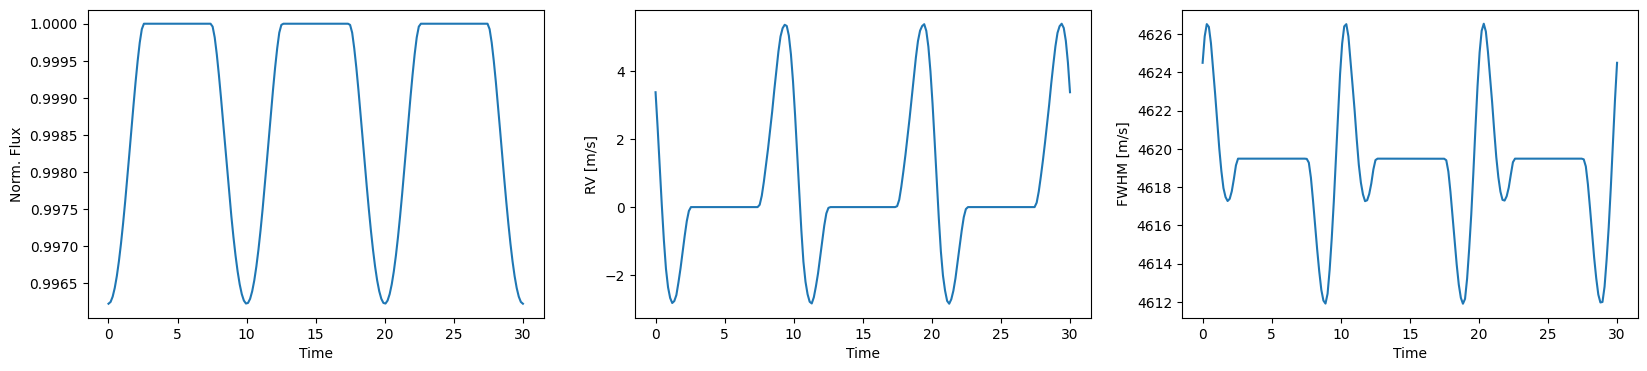

In [7]:
fig, ax = plt.subplots(1,3,figsize=(20,4))
ax[0].plot(t_sampling,ss.results['lc'])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Norm. Flux')
ax[1].plot(t_sampling,ss.results['rv'])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('RV [m/s]')
ax[2].plot(t_sampling,ss.results['fwhm'])
ax[2].set_xlabel('Time')
ax[2].set_ylabel('FWHM [m/s]')
plt.show()

The plots can be automatically generated using the method `ss.plot_forward_results()`. The plot will be saved under the _starsim/plots_ folder. Lets show it with a little trick:

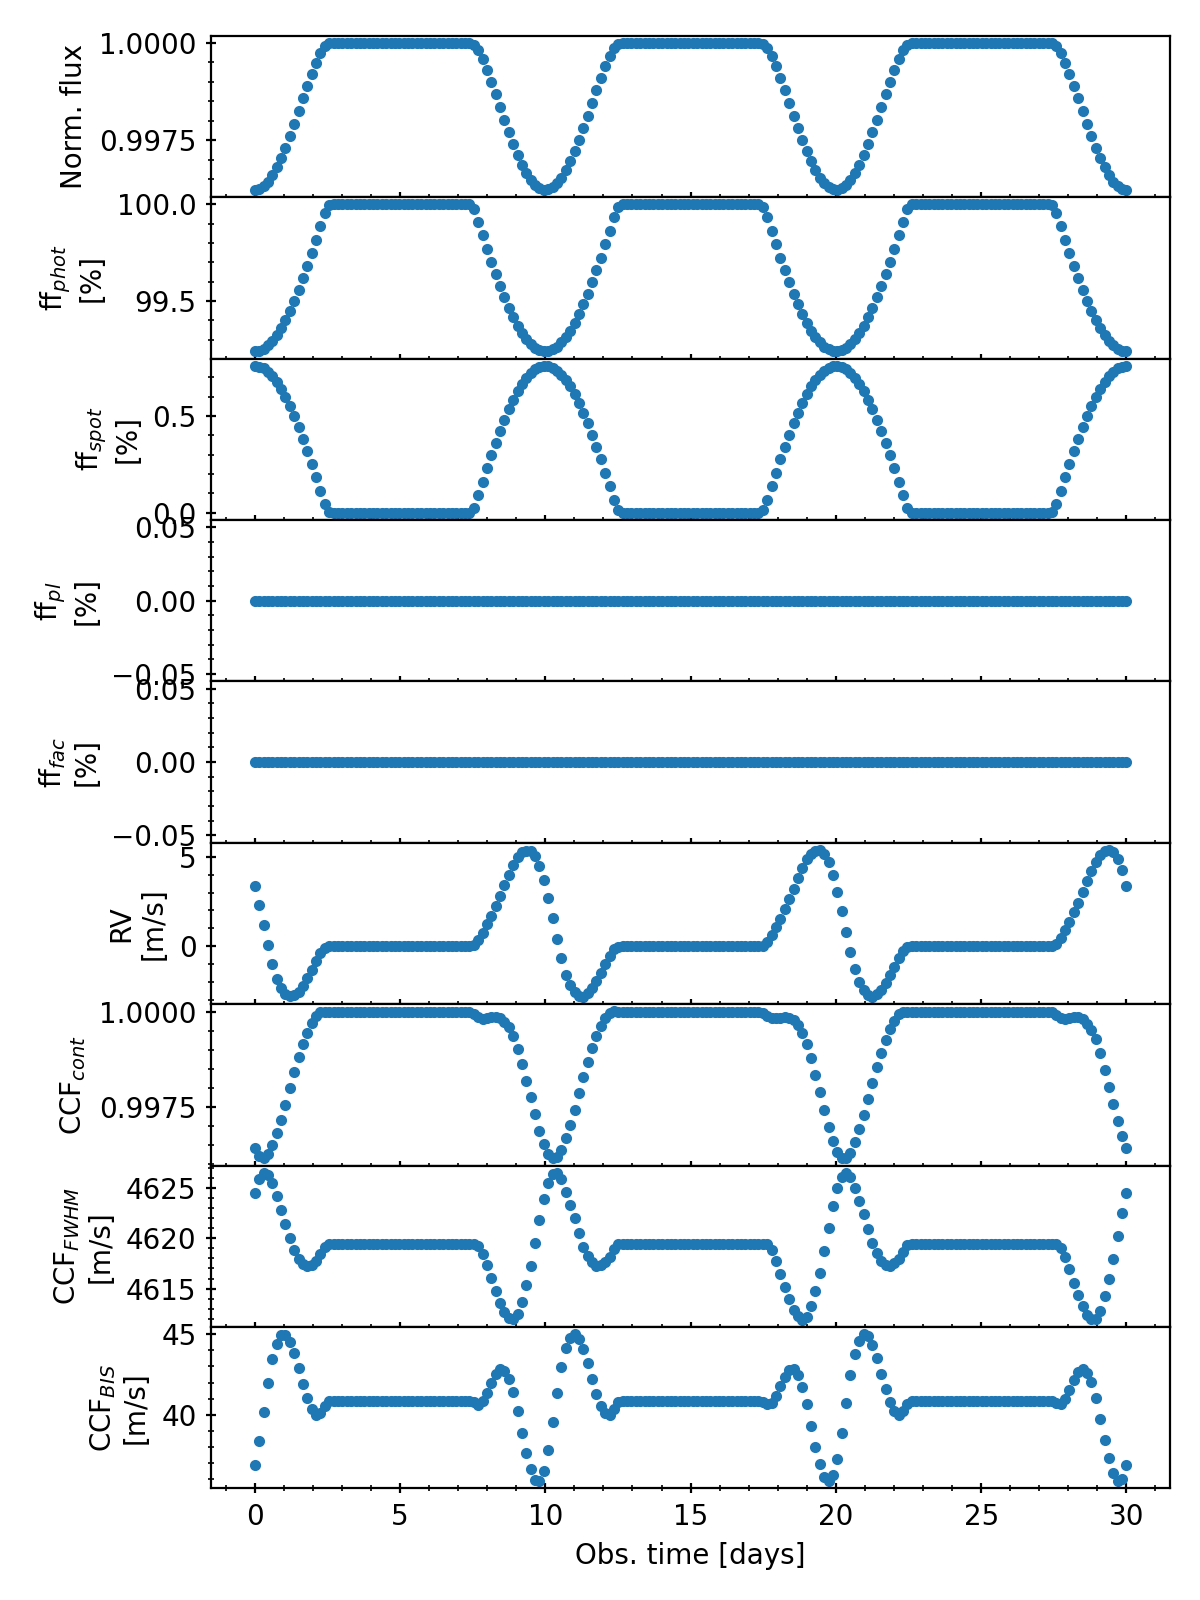

In [8]:
ss.plot_forward_results()
from IPython.display import Image  #trick to show a saved image
Image(filename='starsim/plots/forward_results.png',width=400) 

As you can se the figure contains subplots of more observable than the ones selected, such as the filling factors or all the CCF parameters. 

Note that even though we have set the rotation period to 2.5 with `ss.rotation_period=2.5`, the simulations show that the rotation period is still 10. Bear in mind that every time you define the ss object, it will read the starsim.conf file again and ignore all the changes made before, such as setting the period to 2.5.

### 5.1.- Introducing the chromatic indexs indicators

Starsim can also be tuned to work as an echelle spectrograph, computing the CCF parameters for each of the echelle orders containing a different wavelength range. This can be useful to simulate the dependence of the different parameters with the wavelength, which are called the chromatic indicators. To use this mode, one needs to generate a text file containing the number of order, the initial wavelength, and the final wavelength of a certain spectrograph, and store it in the folder _starsim/orders_CRX_. Lets run again the previous spot map adding the cromatic index and lot the results. Be aware that this mode will be much slower than with the 'lc' or 'rv' observables, since it has to repeat the simulation for each order (it should take ~1 minute). To simulate all the observables, you only need to set `observables=['lc','rv','crx']` as shown below:

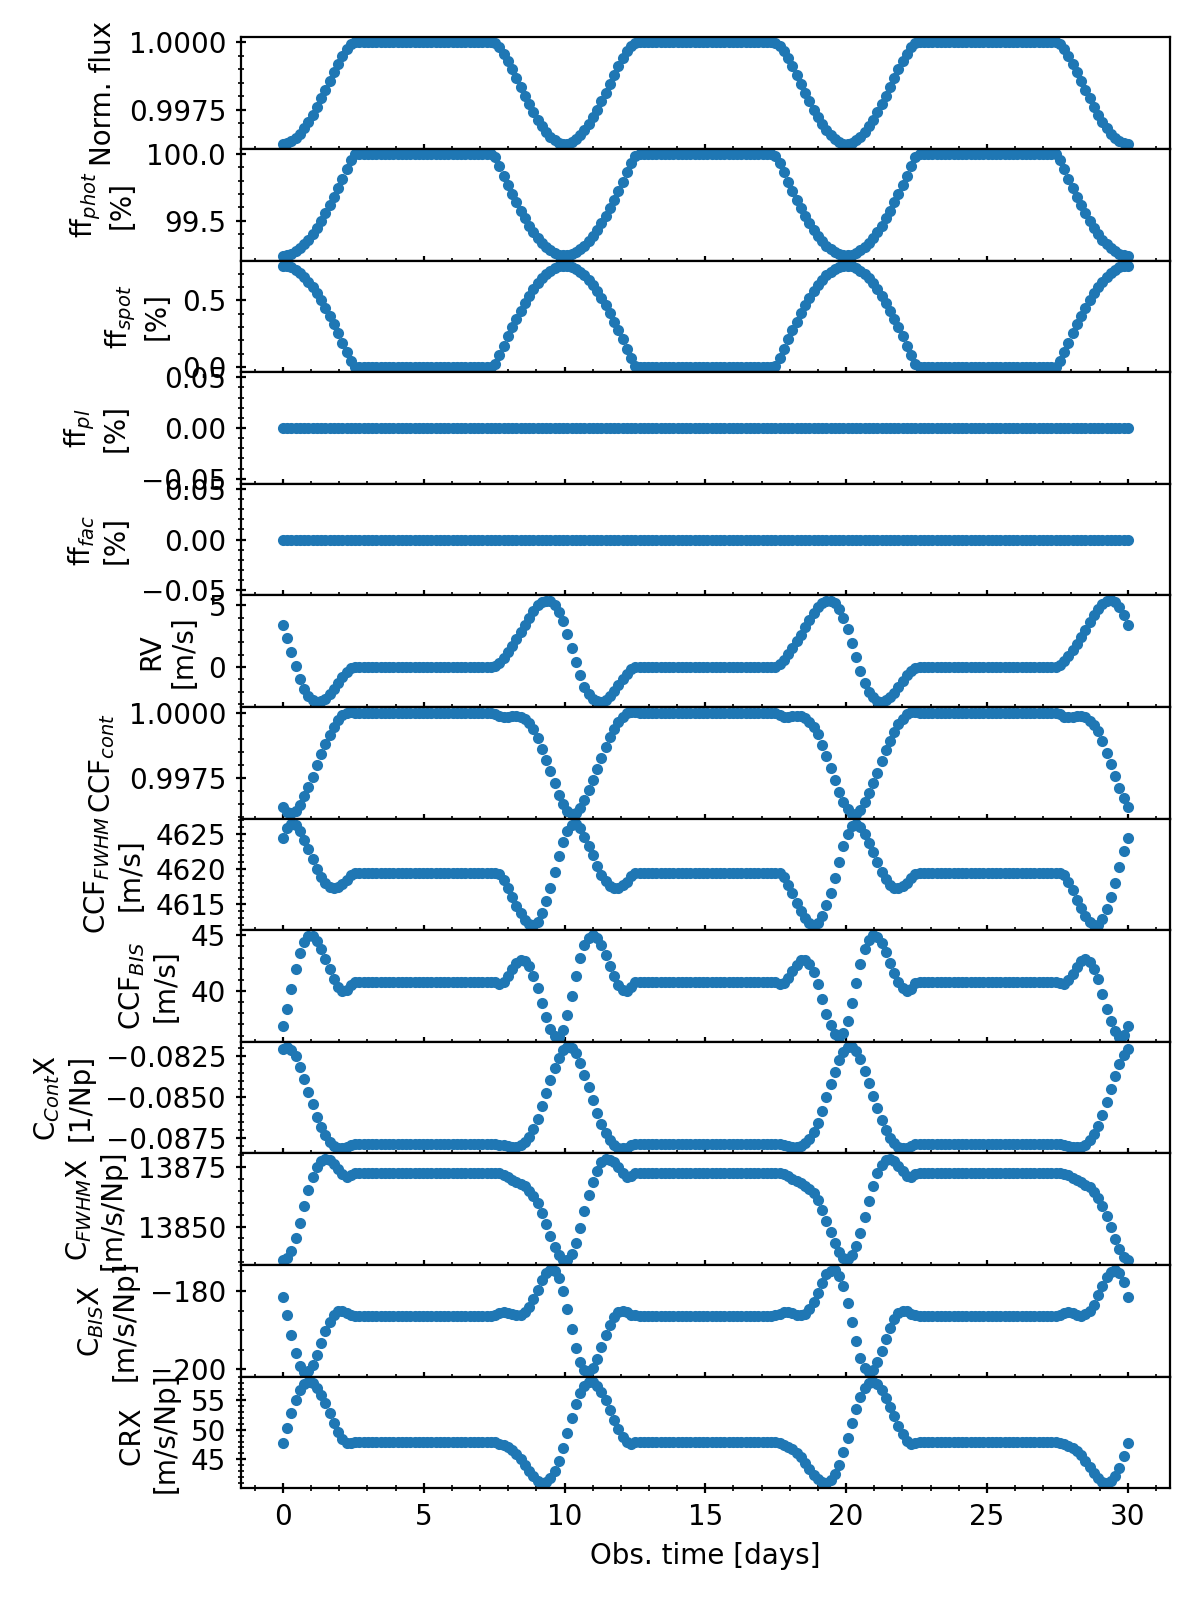

In [9]:
ss.compute_forward(observables=['lc','rv','crx'],t=t_sampling)
ss.plot_forward_results()
from IPython.display import Image  #trick to show a saved image
Image(filename='starsim/plots/forward_results.png',width=400) 

### 5.2.- Adding a planet

starsim can also simulate the effect of a transiting planet over the photometry, and all spectroscopic observables, including the rossiter-mclaughin effect and spot-crossing effects. To include a planet in the simulation, simply set _simulate_planet_ to 1 in starsim.conf, and run the forward model as before. We will reduce the simulated time to highlight the transit.

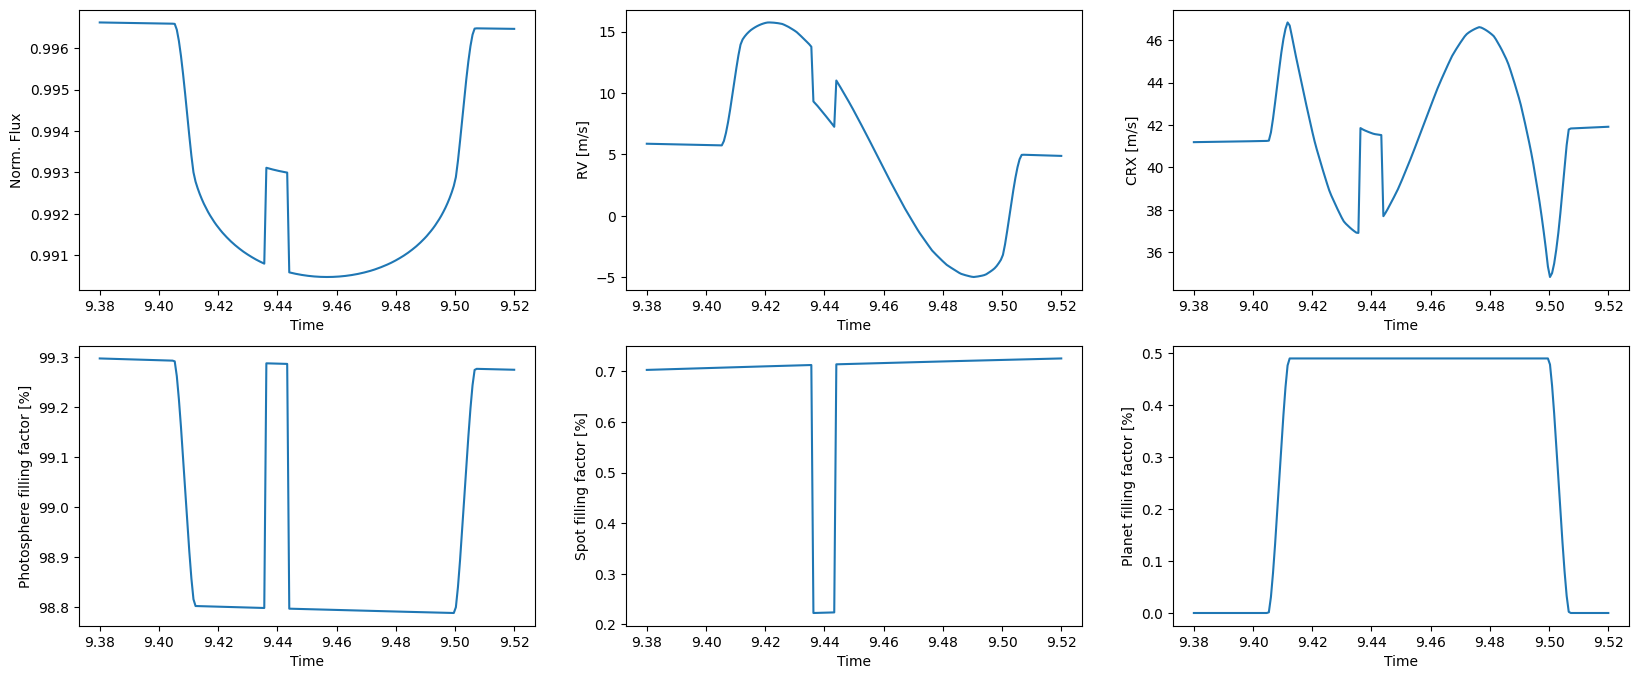

In [10]:
ss.simulate_planet=int(1) #Important to set it as an integer
t_sampling=np.linspace(9.38,9.52,200) #define the sampling time
ss.compute_forward(observables=['lc','rv','crx'],t=t_sampling) #simulate all observables

fig, ax = plt.subplots(2,3,figsize=(20,8))
ax[0,0].plot(t_sampling,ss.results['lc'])
ax[0,0].set_xlabel('Time')
ax[0,0].set_ylabel('Norm. Flux')
ax[0,1].plot(t_sampling,ss.results['rv'])
ax[0,1].set_xlabel('Time')
ax[0,1].set_ylabel('RV [m/s]')
ax[0,2].plot(t_sampling,ss.results['crx'])
ax[0,2].set_xlabel('Time')
ax[0,2].set_ylabel('CRX [m/s]')
ax[1,0].plot(t_sampling,ss.results['ff_ph'])
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Photosphere filling factor [%]')
ax[1,1].plot(t_sampling,ss.results['ff_sp'])
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('Spot filling factor [%]')
ax[1,2].plot(t_sampling,ss.results['ff_pl'])
ax[1,2].set_xlabel('Time')
ax[1,2].set_ylabel('Planet filling factor [%]')
plt.show()

As you can see in the plots, the transit stars at t=9.4, and there is a spot crossing event at t=9.44. This is reflected also in the filling factors.

Starsim not only simulates the drop in flux and the rossiter-Mclaughin effect, but also reproduces the effect over all other observables, such as the CRX. 

The spot crossing event produces a very sharp change in the observables, due to the lack of resolution in the overlapping between spot and planet. To avoid this, one should use the `precise` mode in starsim.cong with a very dense grid, but would be very time consuming to reproduce it here.

## 6.- Inverse mode

In the inverse model, the user provides any number of time-series of different observables, and starsim optimizes the spot map and/or the stellar parameters to match the observations. There are three main modes:

1. Compute N inversions with a given set of stellar parameters to obtain N spot maps. This is done with the method `best_maps, lnLs = ss.compute_inverseSA(N_inversions=N)` and returns the N best maps and log-likelihoods. Also returns the file `inversion_stats.npy` with the best maps and log-likelihoods. Uses the fast mode, so is not recommended for spots larger than ~20 deg.

2. Optimize the stellar parameters. Inside a user-defined range, starsim selects random stellar parameters, and for each set, computes the best spot map and the best likelihood. This method can be called with `ss.optimize_inversion_SA()` and as an output produces the file `inversion_MCMCSA_stats.npy` with the log-likehood, the stellar parameters and spot map of each step. Also recommended for spots larger than ~20deg.

3. Optimize stellar parameters and spot map simultaneously using an MCMC. This method treats the spot parameters as additional stellar parameters, and can be used in both fast and precise modes, so is recommended for stars with big spots or for cases with no more than 2-3 spots. It is executed with `ss.optimize_MCMC()`. The output consists of a plot with the MCMC chains, a corner plot with the results and a list with the optimized parameters and uncertainties. 

### 6.1.- Loading the time series

First of all let's create som dummy observables which we will invert. In this example we are going to use one RV curve and one light curve. To make it simpler, manually modify the `spotmap.dat` file to be:

0.0 40.0 90.0 30.0 5.0 0.0 0.0  0 0 1 1 1 0 0 

0.0 40.0 60.0 310.0 2.0 0.0 0.0  0 0 1 1 1 0 0

That is, two spots spot born at t=-1, with a lifetime of 40 days, at colatitudes of 90 and 60 deg, longitudes of 30 and 310 deg, and radii of 5 and 2 deg. The integers in the last 7 columns are used to fix (0) or optimize (1) the parameters of the first 7 columns. That is, here we will optimize the colatitude, longitude and spot size of both spots.

In [11]:
ss=starsim.StarSim(conf_file_path='starsim.conf') #initialize configuration and spot map
t_sampling=np.linspace(0,30,30) #sampling times
ss.compute_forward(observables=['lc','rv'],t=t_sampling) 

y_lc=ss.results['lc']
dy_lc=0.0001*np.ones(len(y_lc)) #Dummy errors
y_rv=ss.results['rv']
dy_rv=0.01*np.ones(len(y_rv)) #Dummy errors

Lets now load the data into starsim. It is done with the method `ss.load_data`, and it can read data from either a three-column text file using the argument filename, or from already defined python variables, as in this case.

In [12]:
ss.load_data(t=t_sampling,y=y_lc,yerr=dy_lc,instrument='DUMMY-lc',observable='lc',filter_name='TJO_R.dat',wvmin=5500,wvmax=9500,offset=1,jitter=0,fix_offset=True,fix_jitter=False)
ss.load_data(t=t_sampling,y=y_rv,yerr=dy_rv,instrument='DUMMY-rv',observable='rv',wvmin=5500,wvmax=9500,offset=0,jitter=0,fix_offset=True,fix_jitter=False)


Make sure that you specify the correct wavelength range and filter that the instrument is using. In this case we are using the same values as the specified in starsim.conf to run the forward model before, but may be different in your case.
Also, additional options to fit the data is given. If desired, you can add to the data a jitter term and an offset (multiplicative for the lc, fwhm and contrast observables, additive fr the others). Also, you can fix these parameters or let starsim optimize them at each inversion. In this case we are going to fix the offset.

The loaded data can be accesed with `ss.data['INSTRUMENT_NAME']['OBSERVABLE_NAME']`

### 6.2.- Inversion

Let's now invert this data and obtain 4 spot_maps. This can be parallelized, so make sure to use a convinient number of CPUs in the N_cpus option in starsim.conf or through ss.N_cpus. Remember that according to the spotmap file, we are optimizing the colatitude, longitude and size of a single spot. 

The execution of this line of code may take several minutes, but in your terminal it should show a progress bar and detailed information of the status of each inversion, with info about the step number, the acceptance fraction and the current best log-likelihood. In starsim.conf there is an option `N_iters_SA` to control the number of steps in each inversion. The default value is 7000, but can be increased to obtain better results or decreased to obtain faster results.

In [13]:
best_maps, lnLs = ss.compute_inverseSA(N_inversions=4)

Computing 4 inversions of 2 spots each.

Using data from the instruments:
- DUMMY-lc , with the observables:
	- lc
- DUMMY-rv , with the observables:
	- rv


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2012.38it/s]


 Step=6999/7000; Acc_frac=0.0631; lnL=340.442Inversion 1 complete with a lnL of 340.441748171658
 Step=6999/7000; Acc_frac=0.0660; lnL=353.517Inversion 0 complete with a lnL of 353.51689291774636
 Step=6999/7000; Acc_frac=0.0714; lnL=218.148Inversion 2 complete with a lnL of 218.14756102122777
 Step=6999/7000; Acc_frac=0.0820; lnL=278.786Inversion 3 complete with a lnL of 278.78568827221636


The idea of repeating the inversion N times is to increase statistics, since in some cases the optimization may be trapped in a local maxima.
Once the inversion is finished, one can plot the resulting inverted time series with the funcion `ss.plot_inversion_results(best_maps,lnLs,Npoints=500)`, which plot the loaded data togther with the time series obtained by each inversion. The plots of the best spot maps at the desired time stamps are obtained with
`ss.plot_spot_map(best_maps,tref=[t1,t2,t3,...])`. The map of the active regions at each longitude and time is obtained with
`ss.plot_active_longitudes(best_maps,tini=t_sampling[0],tfin=t_sampling[-1],N_obs=200)`.

In [14]:
ss.plot_inversion_results(best_maps,lnLs,Npoints=500)
ss.plot_spot_map(best_maps,tref=[10,11])
ss.plot_active_longitudes(best_maps,tini=t_sampling[0],tfin=t_sampling[-1],N_obs=200)

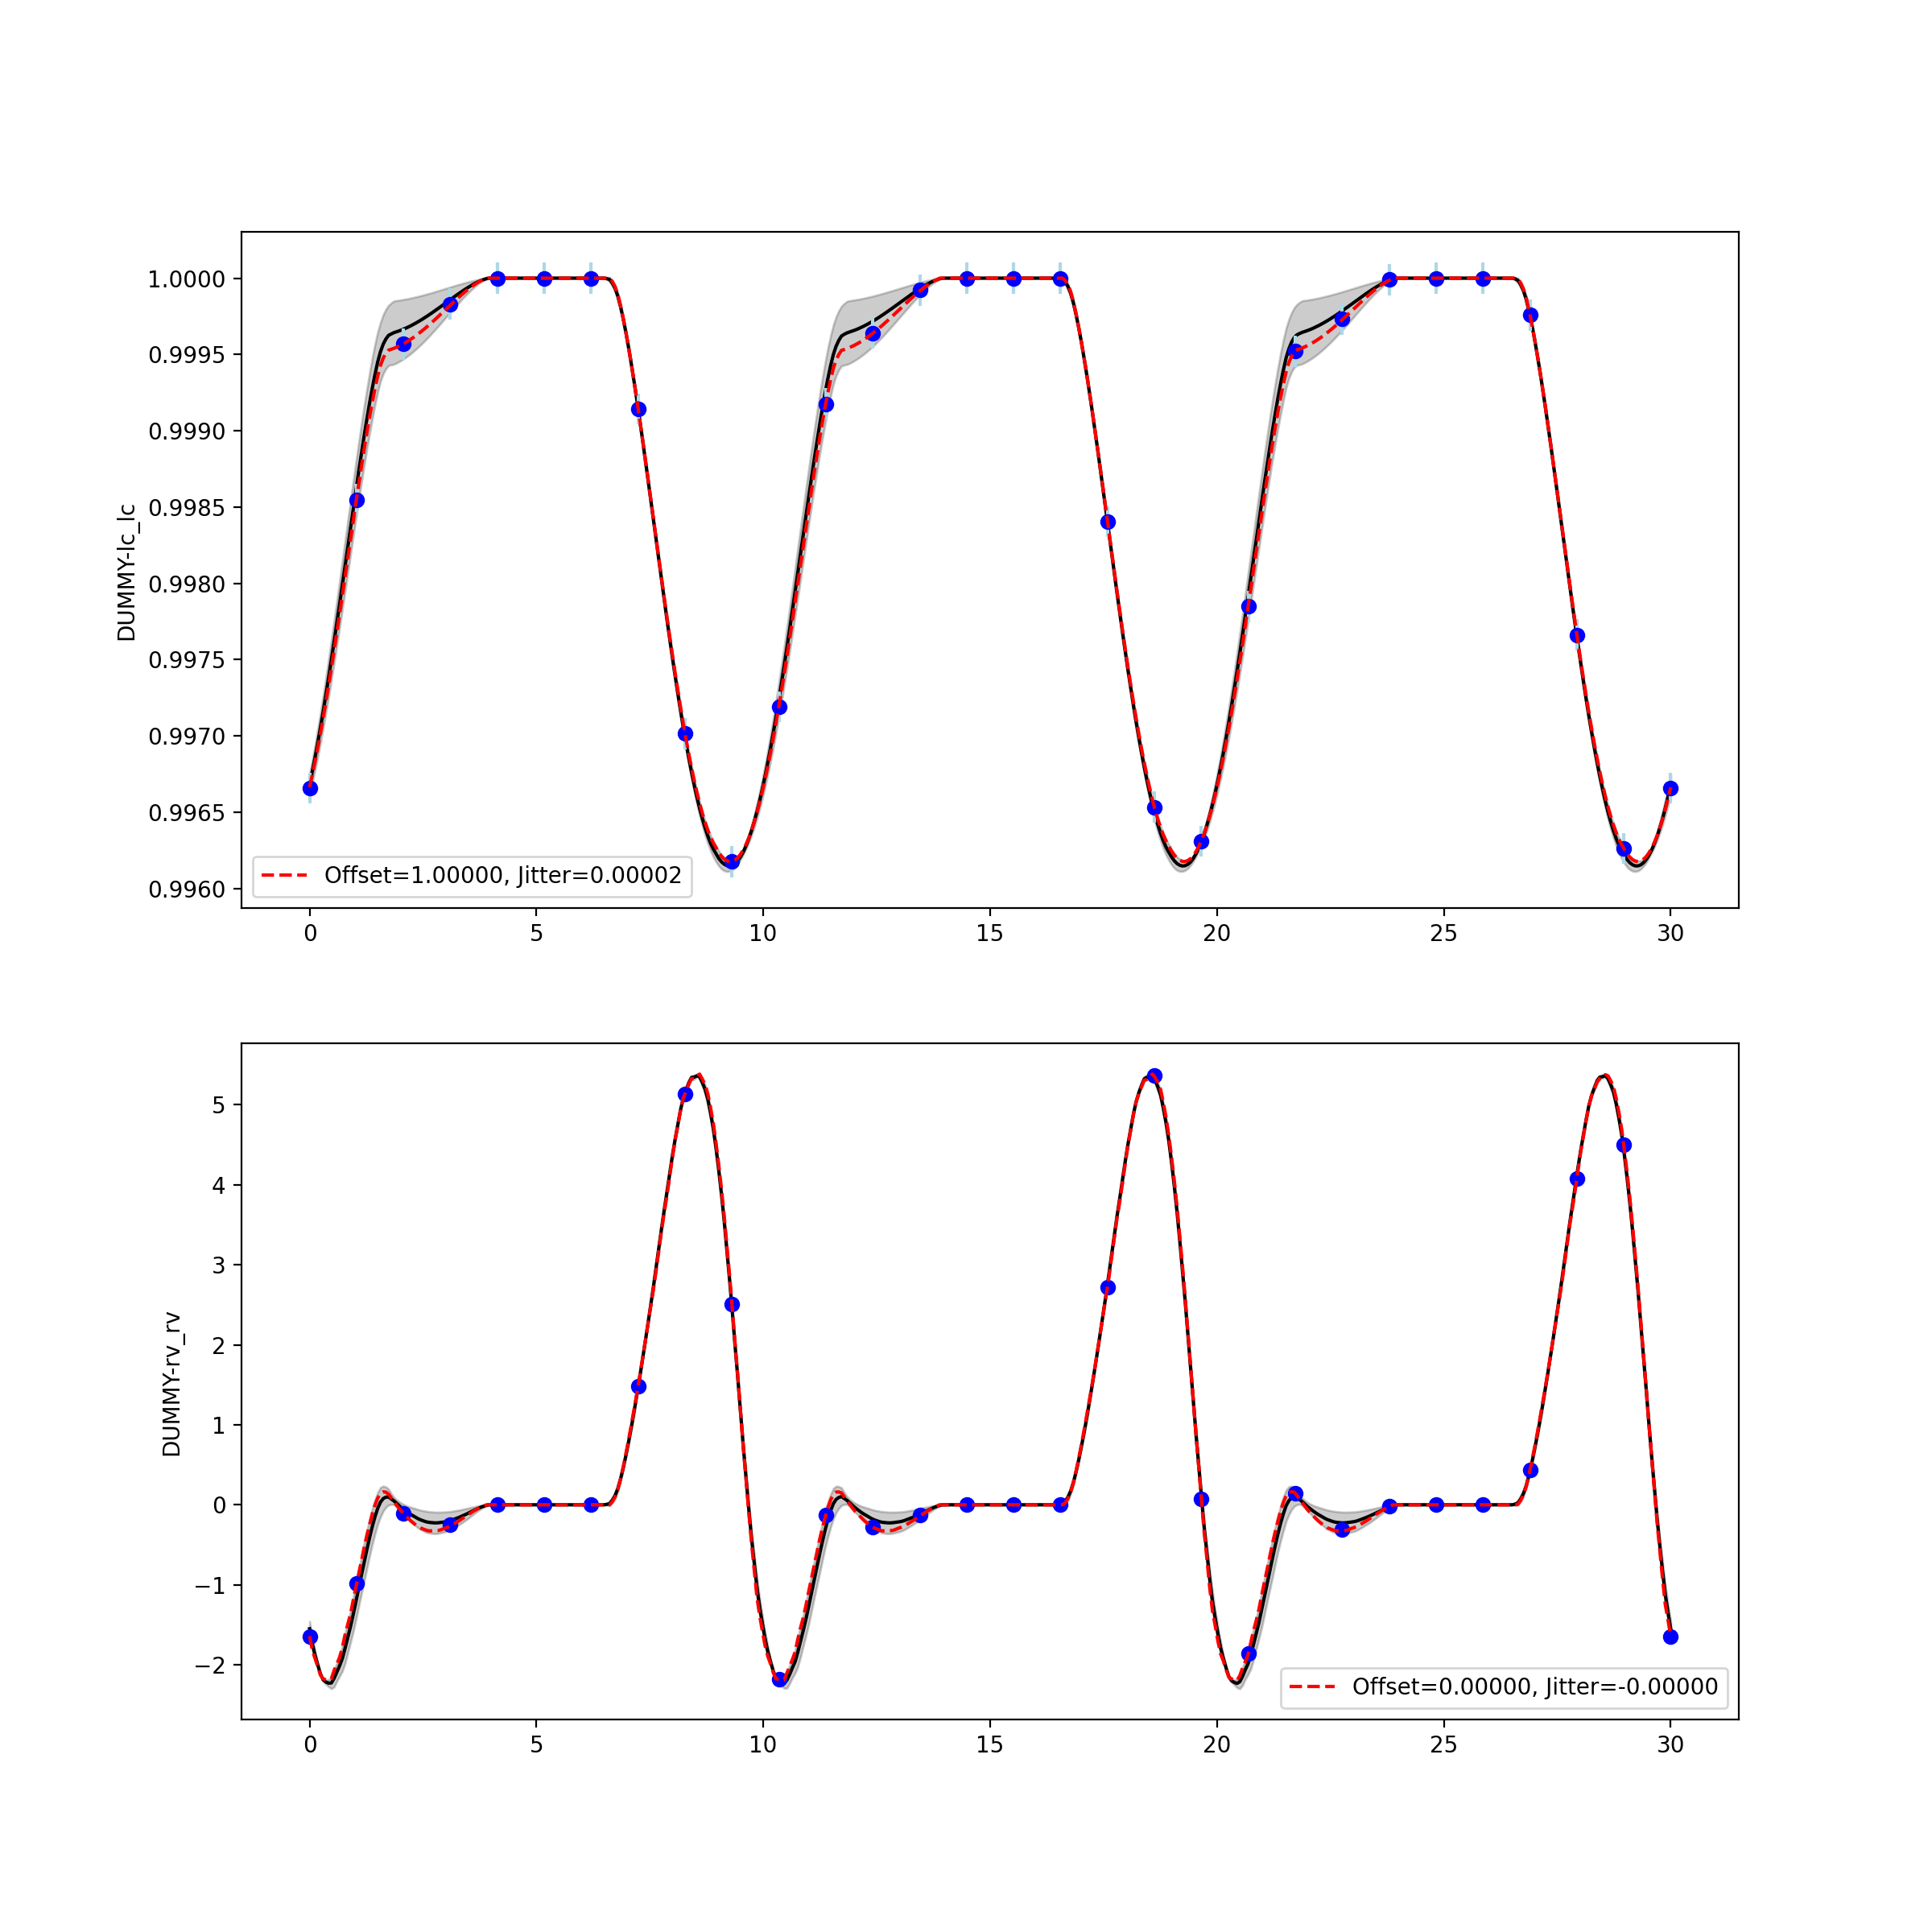

In [15]:
Image(filename='starsim/plots/inversion_timeseries_result.png',width=600) 

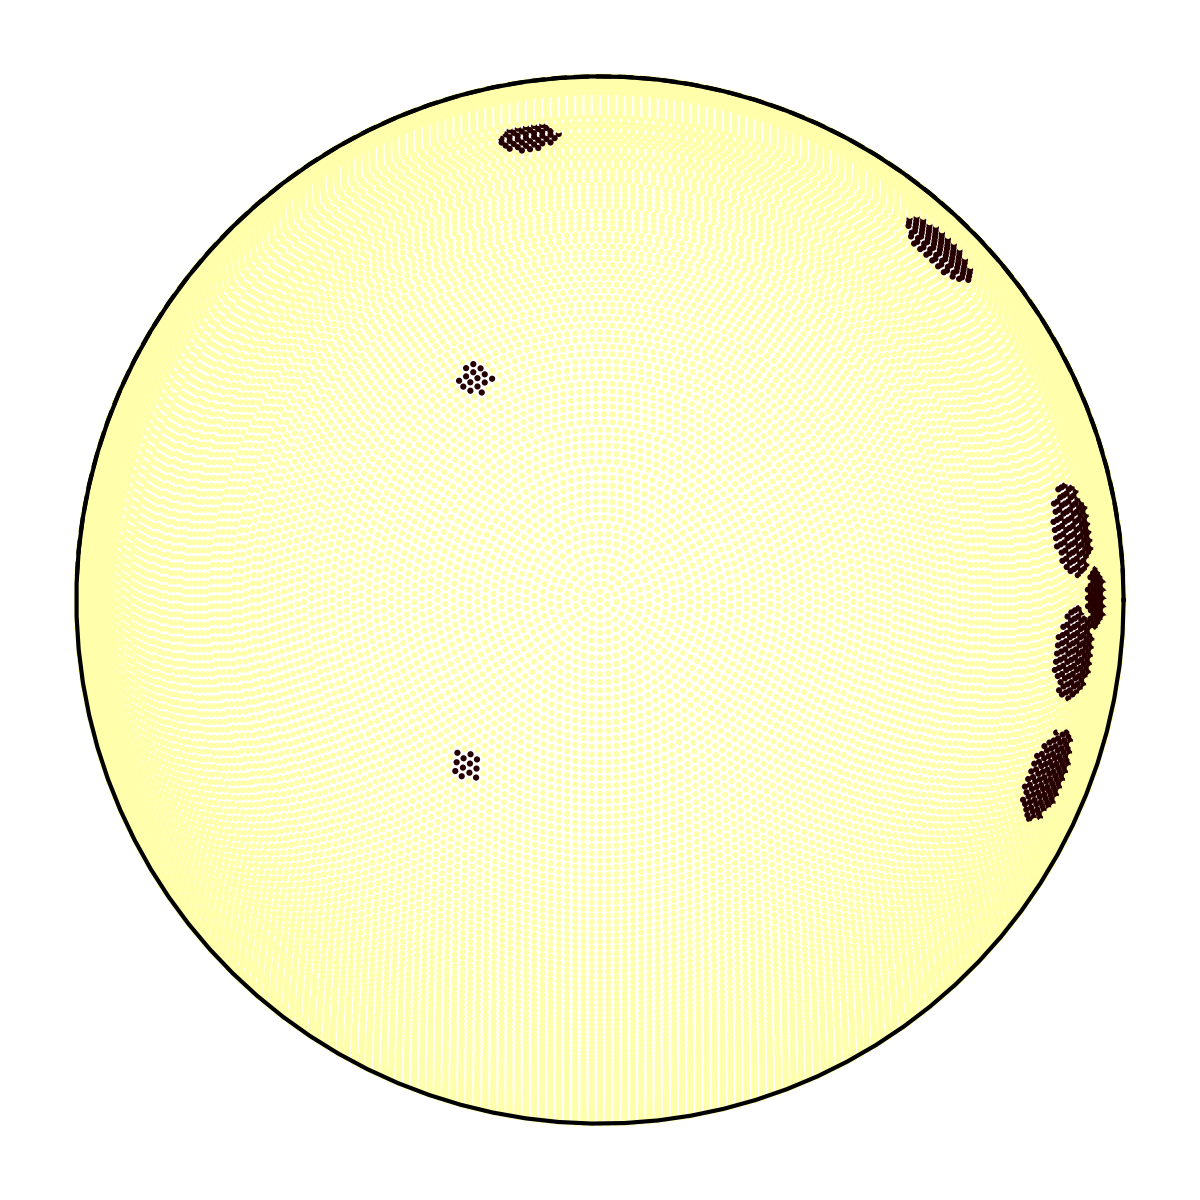

In [16]:
Image(filename='starsim/plots/inversion_spotmap_t_11.0000.png',width=400) 

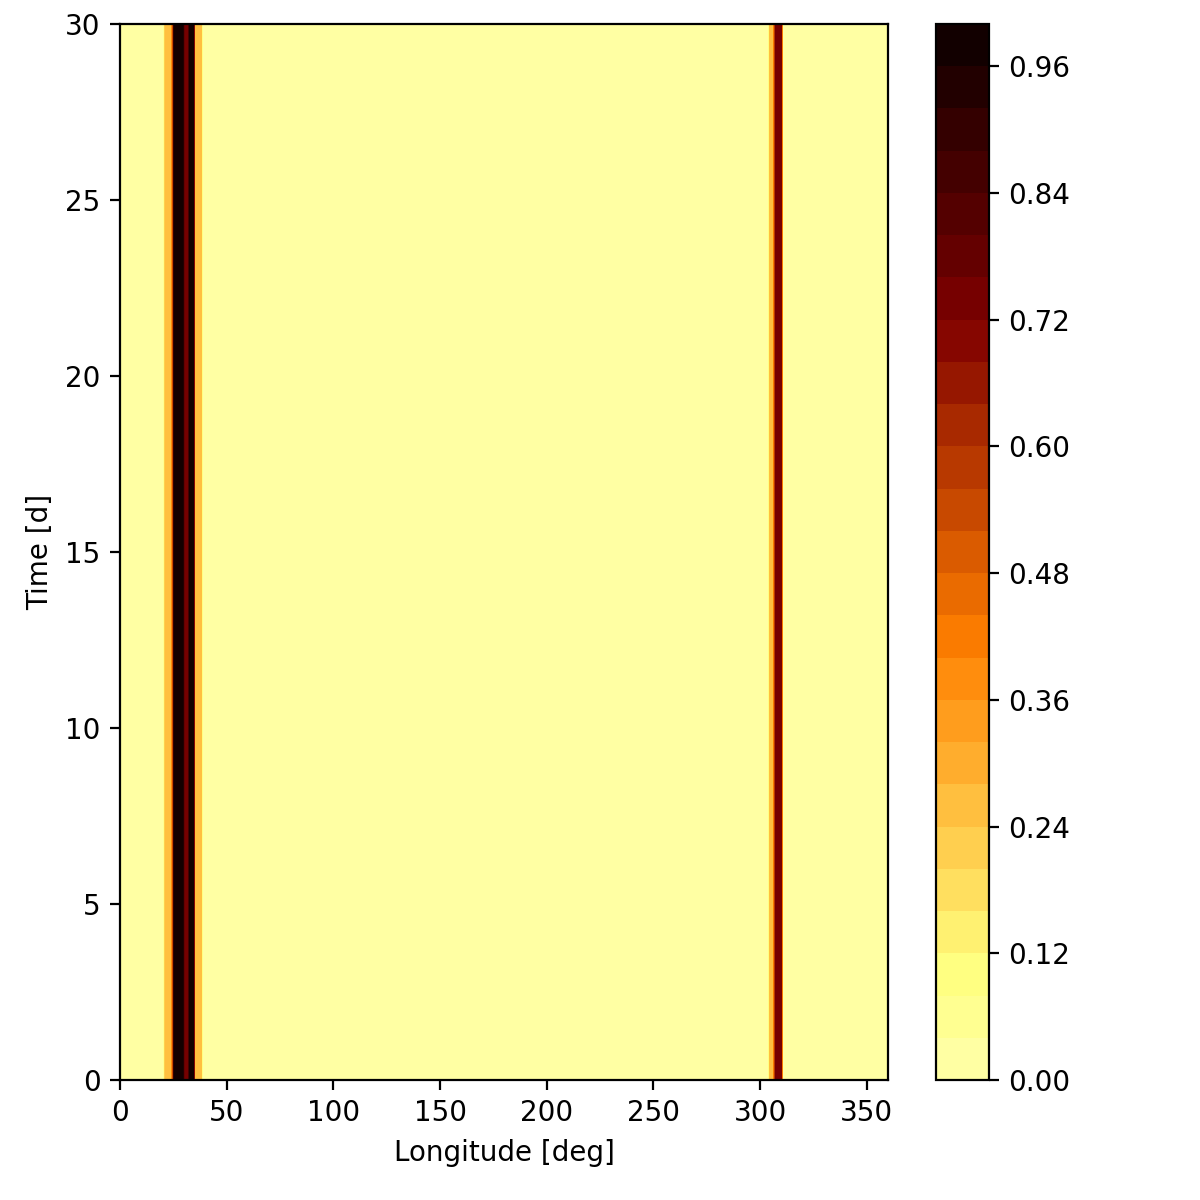

In [17]:
Image(filename='starsim/plots/active_map.png',width=400) 

### 6.3.- Stellar parameter optimization
The stellar parameters of the star can also be optimized by randomly exploring a grid of values and performing an inversion for each of those. This is an expensive routine, that may take several hours depending on the number of iterations you may want. We start by selecting in the configuration file `starsim.conf` the parameters that we want to optimize. Lets optimize the contrast temperature only. You should have something like this at line 88.

#stellar properties  
prior_t_eff_ph :              [0 , 3000 , 6000 , 0 , 4700 , 5500]    # Teff of the star photosphere (K)  
prior_spot_T_contrast :       [1 , 0 , 1000.0 , 0 , 0,500]    # Spot temperature contrast (K)  
prior_facula_T_contrast :     [0 , 0 , 100 , 0 , 0 , 100]    # Facula temperature contrast (K)  
prior_q_ratio :               [0 , 0 , 3 , 0 , 0 , 3]    # Facular to spotted area ratio Q  
prior_convective_blueshift:   [0 , -1 , 1.5 , 0 , -1 , 1.5]    # Convective shift factor.   
prior_p_rot :                 [1 , 9 , 11 , 0 , 9, 11]    # Rotation period (days)  
prior_inclination  :          [0 , 40 , 90, 0 , 40 , 90]    # Inclination of rotation axis (deg, 0 is pole on rotation)  
prior_stellar_radius :        [0 , 0.5, 1.5 , 0 , 0.5 , 1.5]    # Stellar radius (Rsun)  
prior_limb_darkening_q1 :     [0 , 0, 1, 0, 0.3, 0.5] #Limb darkening coefficient q1  
prior_limb_darkening_q2 :     [0 , 0, 1, 0, 0.05, 0.2] #Limb darkening coefficient q2 (don't fit if LD_law is linear)  
#planet  
prior_period_planet:           [0 , 1 , 15 , 0 , 2.77 , 2.78] #period of the planet (days)  
prior_time_transit_planet:	   [0 , 2457400.3 , 2457400.5 , 0 , 2457400 ,2457402.7]  #time of central transit (day)  
prior_semi_amplitude_planet:   [0 , 0 , 2000 , 0 , 120 , 130]  #RV semi-amplitude of panet (m/s)  
prior_esinw_planet:            [0 , -0.7 , 0.7 , 0 , -0.1 , 0.1] #eccentricity times sine of arg. periastron  
prior_ecosw_planet:            [0 , -0.7 , 0.7 , 0 , -0.1 , 0.1]  #eccentricity times cosine of arg. periastron  
prior_radius_planet:           [0 , 0.05 , 0.1 , 0 , 0 , 0.5] #Radius of planet (R*)  
prior_impact_parameter_planet: [0 , 0 , 1 , 0 , 0 , 1] #Impact parameter of the planet. b>1+Rp means no transit.  
prior_spin_orbit_planet:       [0 , 0 , 15 , 0 , 0 , 360]  # Spin-orbit angle of the transit chord (deg)  

Each line corresponds to a different stellar parameter. In brackets, there are 6 numbers: The first one is to optimize it (1) or leave it fixed (0). The second and third are the lower an upper limits where the optimization will be performed. **Make sure that the fixed parameters are within the specified limits, it will not throw an error but infinite log-likelihoods**. The third, fourth and fifth columns are the priors to generate the initial values. In this case we only optimize the spot contrast temperature, with an uniform prior between 0 and 500, and limits between 0 and 1000 (note that since we use an uniform prior there will be no values over 500, the limit is used with none uniform priors).

The last step is to select the number of random evaluations that we starsim will make. This is set with the parameter N_steps in `starsim.conf`. We set a small value of 8 only to sped up the process, but we recommend values larger than 1000 at least.

Before starting the optimization we should restart the ss object to apply the changes in starsim.conf.

In [18]:
ss=starsim.StarSim(conf_file_path='starsim.conf') #initialize configuration and spot map
ss.load_data(t=t_sampling,y=y_lc,yerr=dy_lc,instrument='DUMMY-lc',observable='lc',filter_name='TJO_R.dat',wvmin=5500,wvmax=9500,offset=1,jitter=0,fix_offset=True,fix_jitter=False)
ss.load_data(t=t_sampling,y=y_rv,yerr=dy_rv,instrument='DUMMY-rv',observable='rv',wvmin=5500,wvmax=9500,offset=0,jitter=0,fix_offset=True,fix_jitter=False)


And the optimization is started with:

In [19]:
ss.optimize_inversion_SA()


Using data from the instruments:
- DUMMY-lc , with the observables:
	- lc
- DUMMY-rv , with the observables:
	- rv
Searching random grid for best stellar parameters. Optimizing spotmap at each step.
Total parameters to optimize: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 3317.29it/s]


[412.263  10.38 ] 158.74
[101.562   9.105] 105.56
[298.851  10.901] 122.11
[74.664 10.091] 192.94
[265.054   9.939] 201.27
[262.558  10.323] 170.36
[229.591   9.732] 169.29
[ 1.668 10.925] 92.76


Let's now print the results and plot some figures. It only takes solutions within DeltalnL of the best reusult. We recommend ussing DeltalnL<=15, since are comparable fits, but in this tutorial we use 100 since the number of realizations is really small.

In [20]:
ss.plot_optimize_inversion_SA_results(DeltalnL=100)

Results of the inversion process:
	 -Mean and 1 sigma confidence interval:
	 	 T$_{{eff}}$  =  3500.0 (fixed) 
	 	 $\Delta$ T$_{{sp}}$ = 262.55762+41.74834-162.28925
	 	 $\Delta$ T$_{{fc}}$  =  30.0 (fixed) 
	 	 Fac-spot ratio  =  0.0 (fixed) 
	 	 CS  =  1.0 (fixed) 
	 	 P$_{{rot}}$ = 10.09123+0.31378-0.38975
	 	 inc  =  90.0 (fixed) 
	 	 R$_*$  =  0.5 (fixed) 
	 	 q$_1$  =  0.43 (fixed) 
	 	 q$_2$  =  0.122 (fixed) 
	 	 P$_{{pl}}$  =  0.932 (fixed) 
	 	 T$_{{0,pl}}$  =  2.0 (fixed) 
	 	 K$_{{pl}}$  =  1.0 (fixed) 
	 	 esinw  =  0.0 (fixed) 
	 	 ecosw  =  0.0 (fixed) 
	 	 R$_{{pl}}$  =  0.07 (fixed) 
	 	 b  =  0.0 (fixed) 
	 	 $\lambda$  =  0.0 (fixed) 
	 -Mean and standard deviation:
	 	 $\Delta$ T$_{{sp}}$ = 262.55762+-107.37408
	 	 P$_{{rot}}$ = 10.09123+-0.52288
	 -Best solution, with maximum log-likelihood of 201.2691213920281
	 	 $\Delta$ T$_{{sp}}$ = 265.05386
	 	 P$_{{rot}}$ = 9.93855


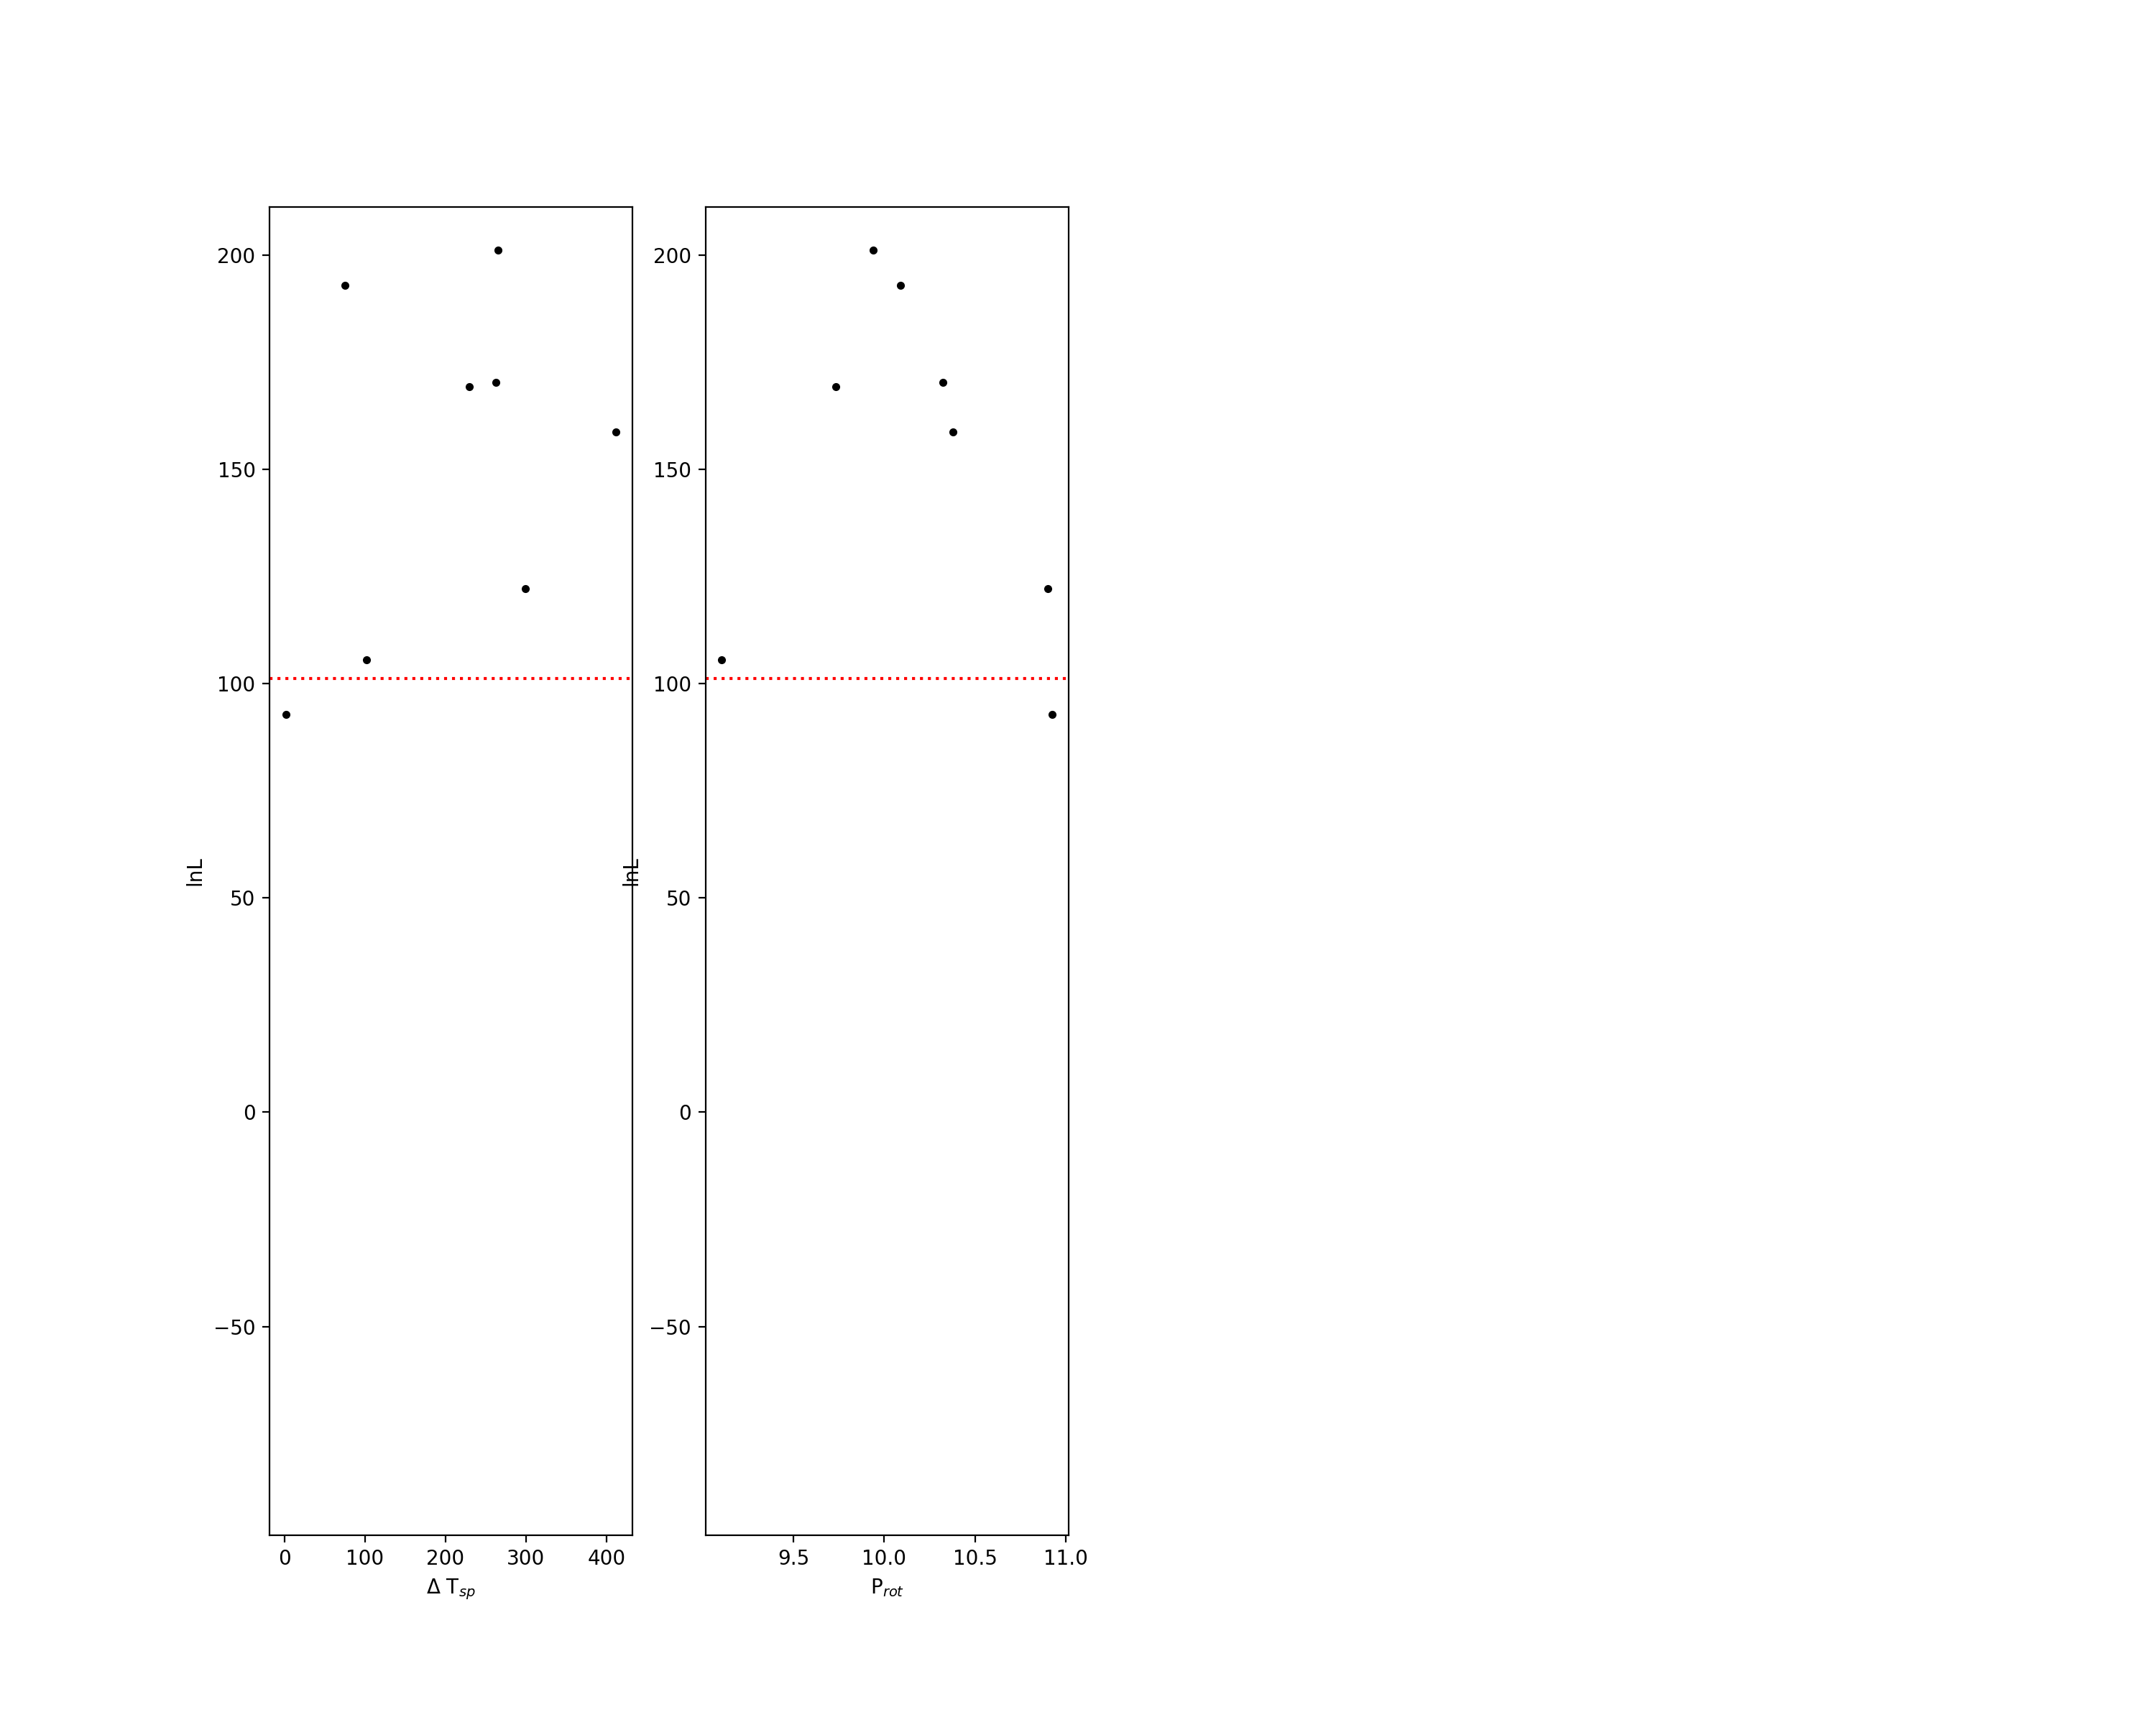

In [21]:
Image(filename='starsim/plots/inversion_MCMCSA_likelihoods.png',width=800) 

This plot the log-likelihoods of each evaluation. As you can see, rotation periods near 10 have the highest likelihoods. However, to obtain significant statistics we should perform much more iterations. The points above the red line are those within DeltalogL, which are selected for the next plots.

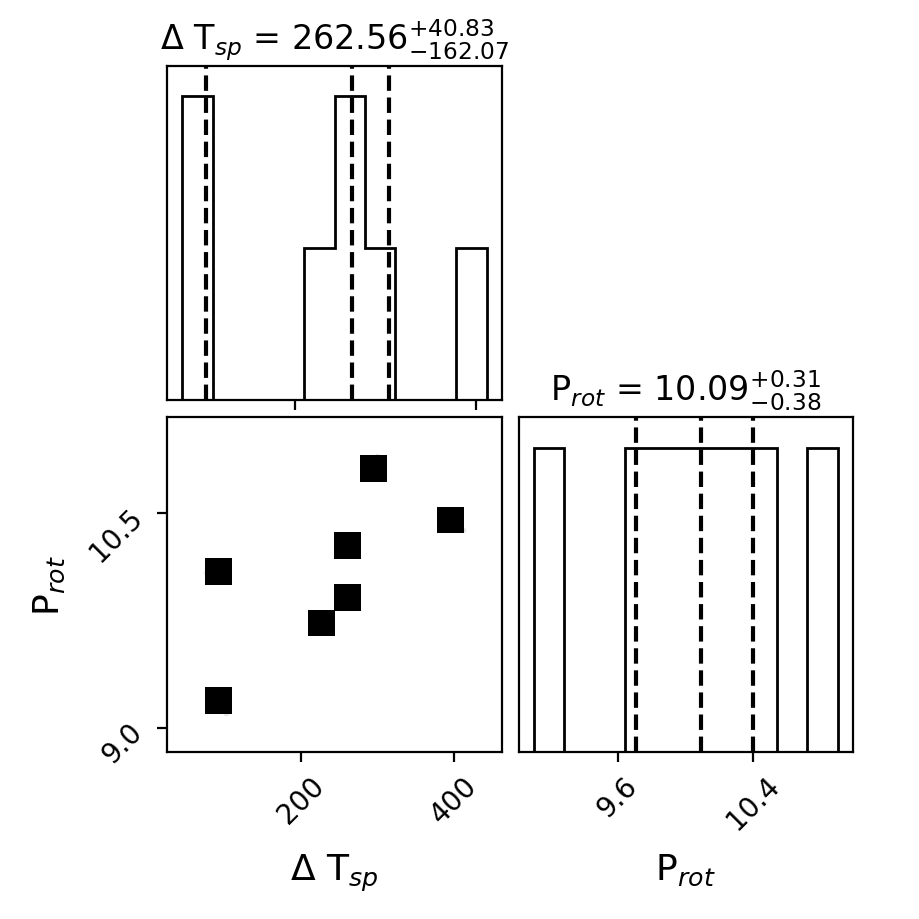

In [22]:
Image(filename='starsim/plots/inversion_MCMCSA_cornerplot.png',width=400) 

With more iterations, the histogram would aproach the input values. Finally, we plot the models of the solutions within DeltalnL.


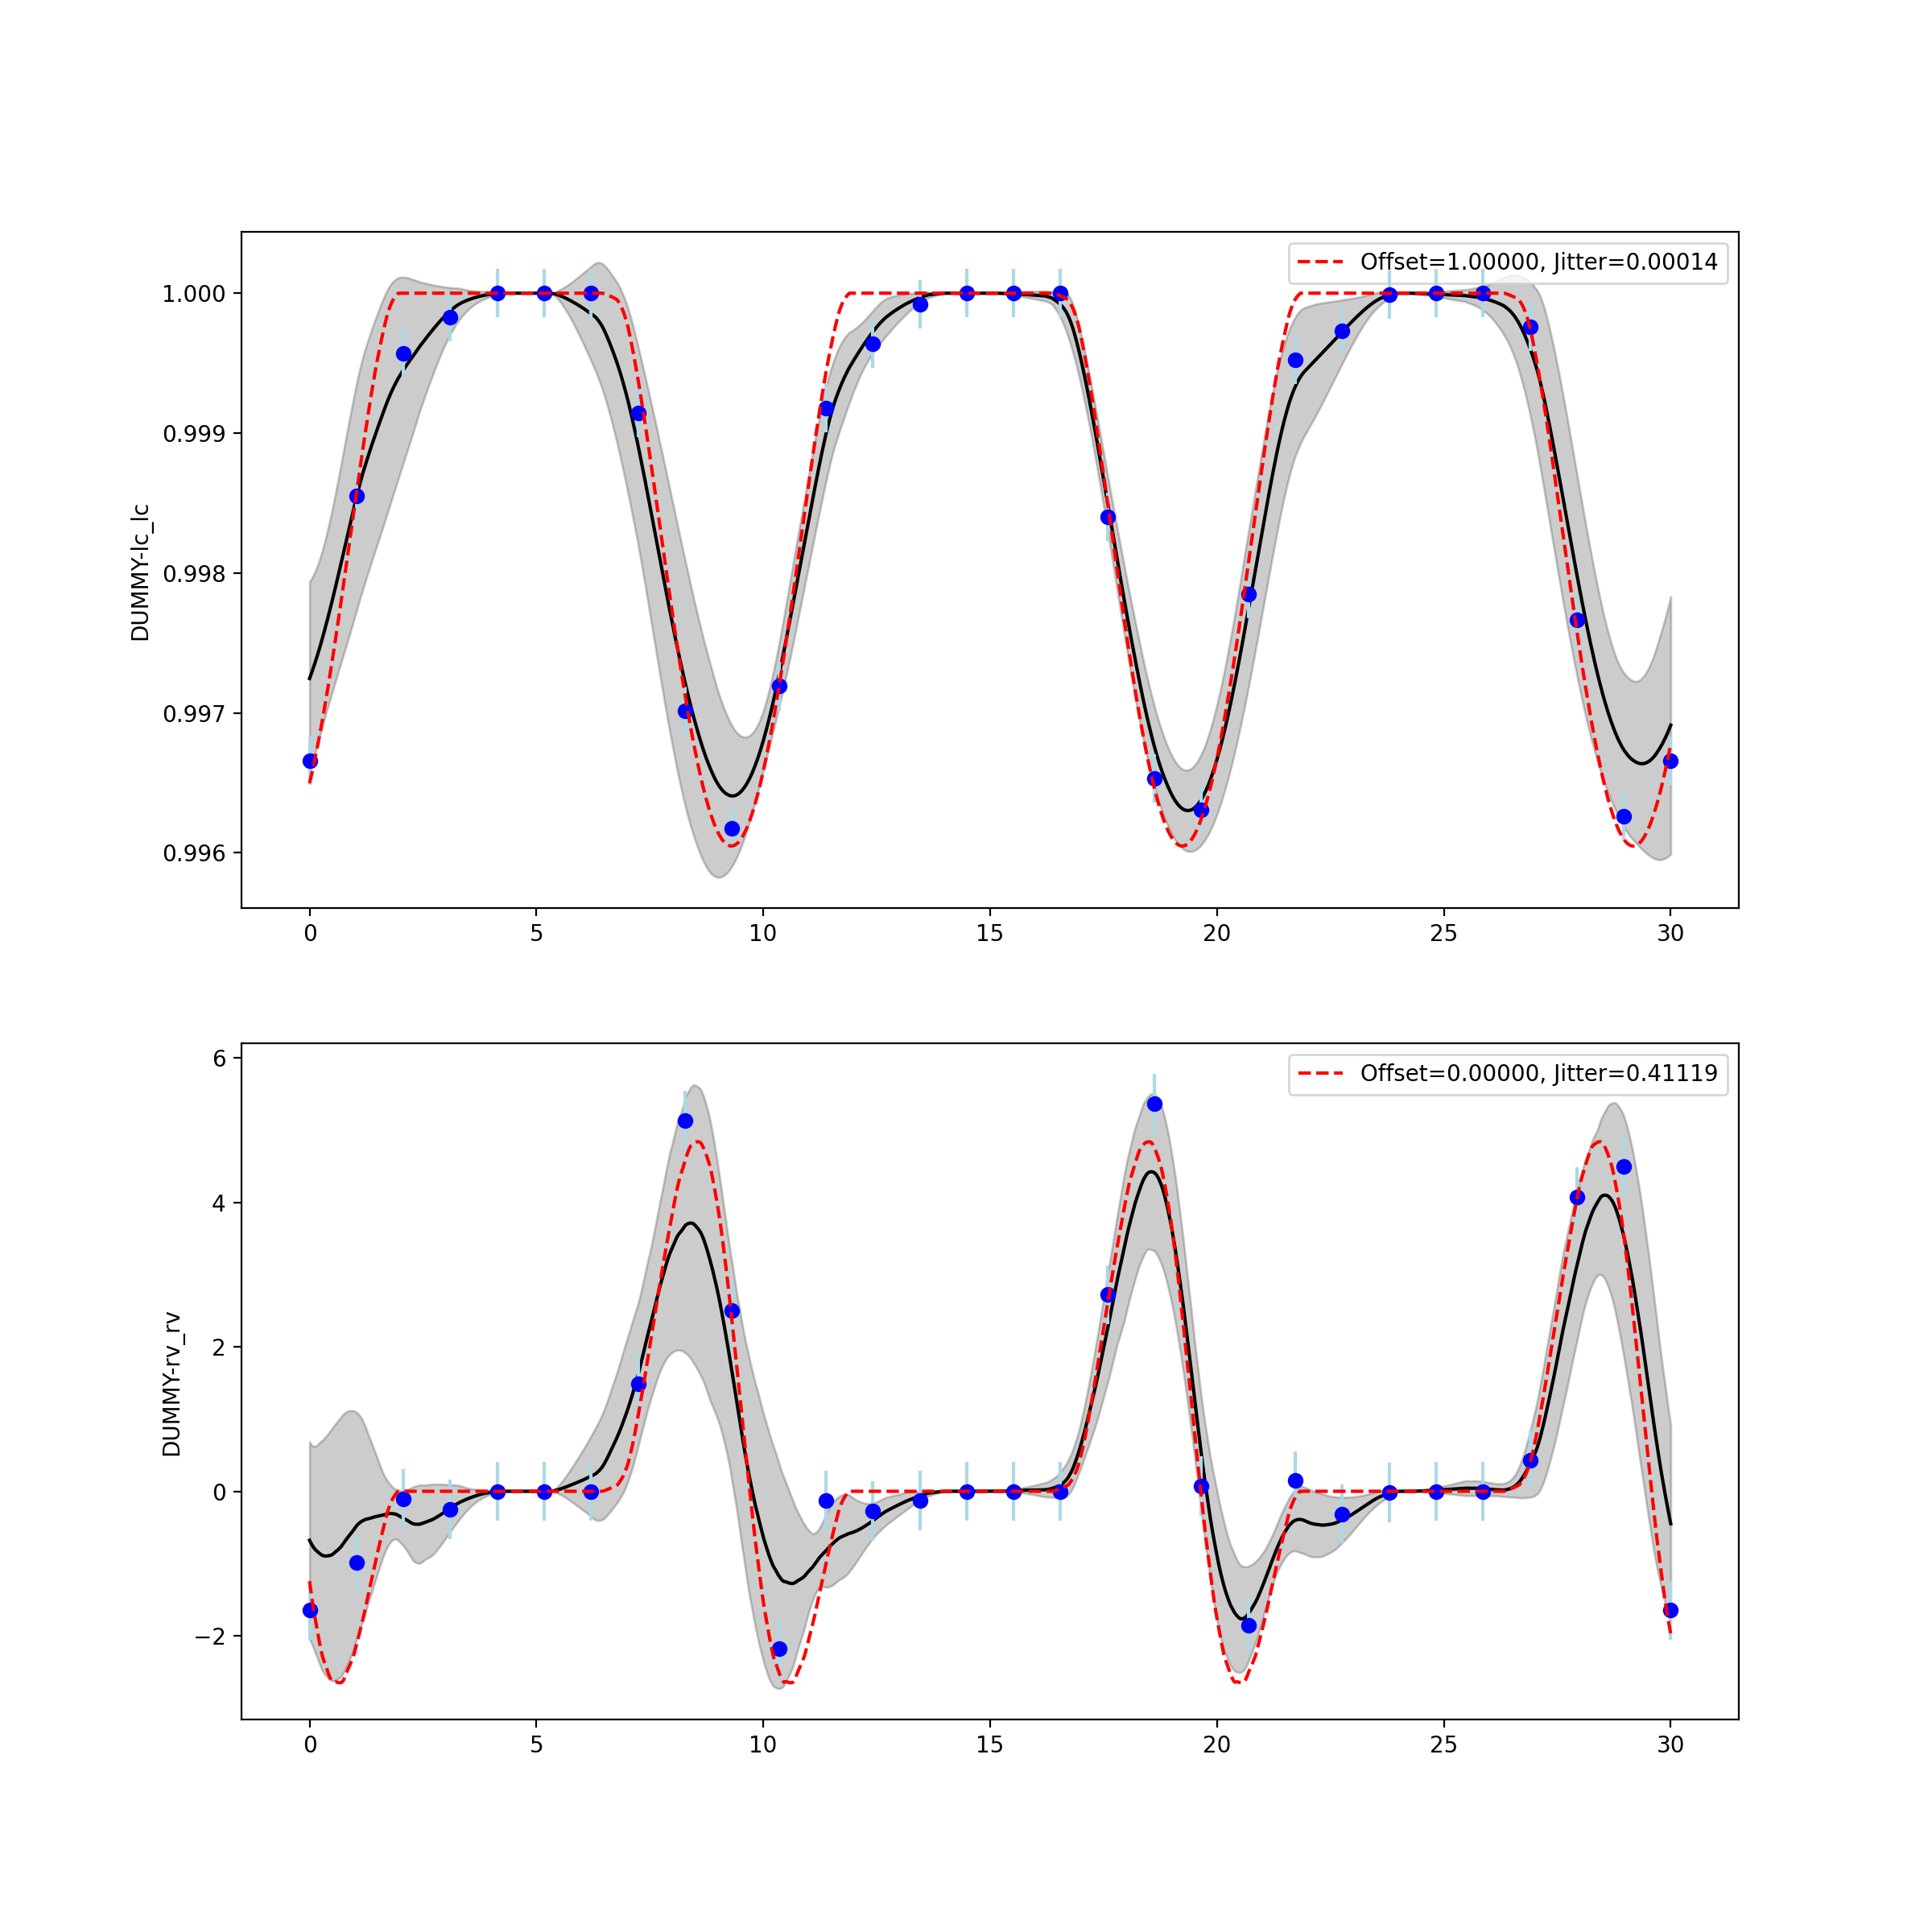

In [23]:
Image(filename='starsim/plots/inversion_timeseries_result.png',width=500) 

If you want to play with the results, they are saved in the file `inversion_MCMCSA_stats.npy`. To acces them simply do:

In [24]:
lnLs, params, best_map = np.load('starsim/results/inversion_MCMCSA_stats.npy',allow_pickle=True)

print('This is the best lnL:',np.max(lnLs))
print('These are the parameters of the best solution',params[np.argmax(lnLs)])
print('This is the best map of the best solution',best_map[np.argmax(lnLs)])

This is the best lnL: -490.7085948212218
These are the parameters of the best solution [5.10000000e+03 1.28619032e+03 3.00000000e+01 0.00000000e+00
 1.45075298e+00 1.15163295e+01 7.04811025e+01 1.04229573e+00
 3.80000000e-01 3.30000000e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
This is the best map of the best solution [[2.45881925e+06 9.99295489e+01 1.74240091e+02 1.90985544e+02
  9.87178530e+00 0.00000000e+00 0.00000000e+00]
 [2.45877754e+06 9.15836602e+01 7.50055585e+01 6.94675106e+00
  1.82315749e+00 0.00000000e+00 0.00000000e+00]
 [2.45880139e+06 2.00272014e+01 1.29580214e+02 2.33163051e+02
  5.27445019e+00 0.00000000e+00 0.00000000e+00]
 [2.45875936e+06 3.87502088e+01 1.91326424e+01 2.13308271e+02
  6.52297318e+00 0.00000000e+00 0.00000000e+00]
 [2.45877241e+06 5.57855501e+01 8.19927268e+01 3.19606418e+02
  1.76824016e+00 0.00000000e+00 0.00000000e+00]
 [2.45876556e+06 9.69740293e+01 6.67397054e+0

### Stellar parameter and spotmap optimization

In some cases when there is only one or two spots, or when the spots are too big for using the fast method (>~20 deg), there is a third option to invert the observed data using either the "fast" or the "precise" modes. This method uses an MCMC chain to simultaneously optimize stellar parameters and spot map. One should specify the number of burn-ins and the number of steps of the chain. Let's optimize now the contrast temperature, the period, and the six parameters of the spot map specified in the spotmap.dat file, with a burn-in length of 100 steps and an additional 100 steps after the burn-in. Once finished, the method will automatically print the results and generate a couple of plots. 


Using data from the instruments:
- DUMMY-lc , with the observables:
	- lc
- DUMMY-rv , with the observables:
	- rv
MCMC uncertainties estimation
Total parameters to optimize: 8
Running first burn-in...
[313.461   9.86   19.089  62.71  328.952 150.176   6.015  28.151] 0.0 -127.86387501905452 -127.86387501905452
[263.38    9.974  81.35   41.341 265.038 352.831   5.967   6.737] 0.0 46.258390335790196 46.258390335790196
[274.871  10.022  35.756  12.291 222.746 264.291  29.678   2.639] 0.0[ 28.87    9.94   53.245  63.244  57.887 326.157  15.405  10.808] 0.0 50.35740515775181 50.35740515775181
 -87.58627647608225 -87.58627647608225
[ 64.683  10.238  66.338  63.509  38.565 184.613   4.103   7.309] 0.0 67.53699061706484 67.53699061706484
[ 23.222   9.967  28.703  87.614 249.09  346.216  17.377  29.306] 0.0 -53.269276740787646 -53.269276740787646
[434.862  10.702  20.486  19.411  54.768 162.359   2.052   5.388] 0.0 80.38548290355635 80.38548290355635
[271.689   9.868  33.688  81.296 122.196 26

  0%|                                                                                                                                                  | 0/2 [00:00<?, ?it/s]

[274.451  10.032  18.451  65.851 239.628 123.699  16.741  26.177] 0.0 -116.25556259457036 -116.25556259457036
[406.17   10.771  38.588  28.955  50.929 150.666  10.334  12.458] 0.0 12.460212646805488 12.460212646805488
[152.727  10.08   52.451  71.074  74.135 220.402   6.678   6.956] 0.0 50.63415440261237 50.63415440261237
[243.918   9.62    6.905   5.769 300.363  72.529   7.858   4.896] 0.0 83.87843086735664 83.87843086735664
[146.352   9.341  19.477  54.889 167.677 115.894  12.644  19.492] 0.0 -50.14591273607343 -50.14591273607343
[403.197   9.989  55.746   9.95  182.753 168.792   0.392   0.437] 0.0 81.3972371556279 81.3972371556279
[358.231  10.148  43.641  35.103   5.137  38.222  26.928  14.779] 0.0 -111.87278598053454 -111.87278598053454
[ 15.797   9.938  51.678  64.465  46.338 324.67   15.931  11.035] 0.0 60.768893871664076 60.768893871664076
[113.025   9.837  61.224  89.502 179.894  91.347   2.872   0.402] [305.572   9.395  46.87   23.569 227.313 162.404   8.927  26.799]0.0  80.2

 50%|█████████████████████████████████████████████████████████████████████                                                                     | 1/2 [00:05<00:05,  5.71s/it]

[ 49.005  10.18   49.785  30.923 369.896  75.797  25.126  10.522] 0.0 -34.93697087413207 -34.93697087413207
[ 19.174  10.319  73.516  59.598  20.179 166.113   2.772   7.492] 0.0 65.32334499800194 65.32334499800194
[197.446   9.345  32.614  40.028 175.461 123.302  11.549  22.539] 0.0 -58.287574564059625 -58.287574564059625
[410.997  10.602  20.184  26.32   82.27  156.607   4.237   8.481] 0.0 56.63280502420682 56.63280502420682
[266.014  10.477  41.917  38.558  44.398  55.291  21.577   6.657] 0.0 -61.523176800193184 -61.523176800193184
[402.061   9.968  54.238  11.775 190.511 172.404   0.673   1.553] 0.0 81.36403841446764 81.36403841446764
[249.135   9.469  53.727  17.602 214.021 127.123  11.91   25.175] 0.0 -30.719731134333784 -30.719731134333784
[291.825   9.963  37.516  42.626  55.268  74.093  23.263  16.697] 0.0 -92.16894180362115 -92.16894180362115


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.01s/it]


Running second burn-in...
[261.586   9.8     5.295   9.583 367.287  17.823   7.413   1.418] 0.0 83.69396028911076 83.69396028911076
[242.299   9.61    2.924   4.33  308.582  41.479   8.366   7.945] 0.0 83.39846837900163 83.39846837900163
[178.133   9.543   1.165   1.552 340.919  97.743   4.477   3.486] 0.0 81.44157050307183 81.44157050307183
[129.235   9.802  16.93   21.162 316.846  88.838  11.431   8.843] 0.0 88.80461947265407 88.80461947265407
[214.918   9.805   6.312  15.13  278.67   42.218   8.178   5.948] 0.0 88.80928209202135 88.80928209202135
[344.446   9.386   2.232   7.023 302.874 110.323   7.513   3.459] 0.0 82.54496624913934 82.54496624913934
[287.557   9.992   4.358  10.724 318.95   91.944   3.666   2.243] 0.0 81.74176900878588 81.74176900878588
[253.774   9.731   6.036   1.422 308.482  75.166   6.429   5.052] 0.0 83.14021781266065 83.14021781266065
[254.583   9.664  17.896  13.219 310.763  -4.141   8.252   8.029] 0.0 98.56539799121407 98.56539799121407
[289.979   9.708  17

  0%|                                                                                                                                                  | 0/2 [00:00<?, ?it/s]

[226.259   9.589  11.926  14.712 340.421 116.18    7.958   1.967] 0.0 90.0687869584643 90.0687869584643
[321.119   9.501  22.497   1.463 261.529  86.959   8.204   3.439] 0.0 73.4427032090405 73.4427032090405
[339.281   9.462  15.877   2.285 295.848 115.579  10.041   8.902] 0.0 85.68673187728724 85.68673187728724
[264.26    9.549  10.641  12.359 282.416  14.022  10.386   8.235] 0.0 95.98145323314701 95.98145323314701
[286.985   9.638  14.677   4.3   318.878 104.808  10.762   2.756] 0.0 94.27582297146445 94.27582297146445[243.288   9.863  15.104  14.819 293.897  53.561   9.139   5.795]
 0.0 88.1744539345785 88.1744539345785
[140.877   9.973  11.575   8.595 300.519  95.911   7.701  11.185] 0.0 82.13947106447986 82.13947106447986
[287.259   9.897   8.777  26.175 322.239  74.185  12.08    3.331] 0.0 94.49788213700016 94.49788213700016
[307.867   9.911   9.011   9.036 284.827  81.324   2.144   2.649] 0.0 81.47180543055265 81.47180543055265
[252.54    9.479   6.9     0.837 258.738  74.01    6

 50%|█████████████████████████████████████████████████████████████████████                                                                     | 1/2 [00:05<00:05,  5.59s/it]

[326.272  10.076  12.399  28.975 308.104  97.893   8.378   0.18 ] 0.0 84.56654735126645 84.56654735126645
[235.228   9.724  10.966  13.442 244.547  31.598   6.656   6.354] 0.0 87.34995308315128 87.34995308315128
[162.814   9.25    6.245   2.085 312.012  50.571  10.677   6.126] 0.0 85.02802752924124 85.02802752924124
[287.503   9.921  19.152  18.098 326.286   0.211   5.876   9.518] 0.0 101.16599181532416 101.16599181532416
[286.212   9.881   4.311  18.707 319.127  66.066   5.123   1.618][123.142   9.879  14.564  23.24  346.503  69.482  12.757  13.483]  0.00.0  87.1193233666685182.6992651219202  82.699265121920287.11932336666851



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.60s/it]


Running production...


  0%|                                                                                                                                                  | 0/8 [00:00<?, ?it/s]

[283.048   9.433  21.582   5.793 276.548 100.519   9.64    0.388] 0.0 74.04000673041047 74.04000673041047
[265.737   9.677  25.648  18.398 262.357  58.108  10.158   6.595] 0.0 59.88272291428795 59.88272291428795
[418.636   9.785   9.912  16.55  311.367  80.359   4.656   5.477] 0.0 83.43544388077588 83.43544388077588
[343.277   9.638  22.912   5.755 274.518  78.049  11.635   1.694] 0.0 49.61628486107125 49.61628486107125[313.631  10.082  19.977  26.652 332.56   14.841   3.946   5.753]
 0.0 113.26100479131472 113.26100479131472
[377.412   9.501  30.733   2.919 217.169  60.2     9.077   2.377] 0.0 45.652310658222945 45.652310658222945
[275.2     9.827   5.149   2.691 253.235  57.088  13.086   4.847] 0.0 81.02226851436893 81.02226851436893
[211.147   9.686   6.344  17.855 369.224  64.425   5.965   1.171] 0.0 82.50734693701436 82.50734693701436


 12%|█████████████████▎                                                                                                                        | 1/8 [00:04<00:30,  4.33s/it]

[359.679   9.832   7.601  18.585 369.004  20.913   6.358   1.671] 0.0 86.22765033160692 86.22765033160692
[330.002  10.166  16.473  18.745 313.557  -9.563   3.036   7.588] 0.0 92.89892153055646 92.89892153055646
[306.561   9.767  16.001   3.324 285.947 114.095  13.571   0.913] 0.0 64.187665128268 64.187665128268
[304.748   9.417  26.001   9.371 280.532 111.362   9.114   1.604] 0.0 66.9824482831702 66.9824482831702
[236.592   9.572  17.31    4.551 365.872  46.595  12.682  11.246] 0.0 92.78391712910502 92.78391712910502
[281.636   9.821  21.822  37.325 352.866 107.461  13.914   3.103] 0.0 65.72359657554547 65.72359657554547
[266.329   9.453  21.72   14.736 312.484 123.197   9.014   1.008] 0.0 95.12194981784864 95.12194981784864
[ 85.303   9.635   5.804  29.065 306.262  81.593  12.123   3.324] 0.0 84.19055700603252 84.19055700603252
[251.542   9.844  20.287  18.169 252.54    1.119   5.955   8.815] 0.0 106.27567593326003 106.27567593326003
[383.021   9.577   1.617   1.539 297.04  116.252  

 25%|██████████████████████████████████▌                                                                                                       | 2/8 [00:11<00:35,  5.97s/it]

[295.124   9.925   6.78   17.419 261.42   56.504  16.449   3.823] 0.0 72.08964302850285 72.08964302850285
[ 90.041   9.226   4.247   3.866 350.275 102.763  13.935   6.143] 0.0 82.65916874339148 82.65916874339148
[370.989   9.877   7.999  24.514 315.371 118.675  10.752   1.614] 0.0 88.55231023924732 88.55231023924732
[286.681  10.081  23.945   9.601 214.965   6.308   7.111  12.642] 0.0 84.29692649558243 84.29692649558243
[435.57    9.617   5.228  12.328 354.741 154.974   5.13    7.982] 0.0 78.44990214883771 78.44990214883771
[204.899  10.074  23.746  22.187 330.032  94.77   11.017   9.772] 0.0 68.90056055524752 68.90056055524752


 38%|███████████████████████████████████████████████████▊                                                                                      | 3/8 [00:15<00:24,  4.94s/it]

[283.536  10.106  24.458  34.793 277.115  -3.124   6.836   2.297] 0.0 79.28711086741755 79.28711086741755
[363.445   9.447   0.293   2.514 329.972 106.965   3.325   6.903] 0.0 81.27259982965278 81.27259982965278
[286.117   9.701   7.569   2.885 250.687  83.867   6.043   1.247] 0.0 81.92258490063367 81.92258490063367
[339.122   9.791  16.521  18.735 354.633 151.252   8.945   3.927] 0.0 112.00304533807221 112.00304533807221
[268.072   9.638  17.22    7.614 310.803 123.789   6.815   0.924] 0.0 88.51002264768123 88.51002264768123
[401.43    9.718  12.09   14.454 289.325  73.067  10.16    0.116] 0.0 82.93804715346297 82.93804715346297
[319.095   9.492  22.105  10.664 307.858 130.572  10.159   3.148] 0.0 78.16489623977142 78.16489623977142
[189.565   9.421   9.728  15.083 320.138  70.031  12.887   3.381] 0.0 96.73001704737673 96.73001704737673
[141.009   9.949   8.51   14.111 280.077  65.436   9.664   8.985] 0.0 88.062014113622 88.062014113622
[220.423   9.676  10.484  11.512 270.691  11.047

 50%|█████████████████████████████████████████████████████████████████████                                                                     | 4/8 [00:21<00:21,  5.30s/it]

[216.672   9.685  11.368  26.41  333.083   5.207  11.18    6.255] 0.0 122.98985309527299 122.98985309527299
[296.026   9.708  14.031   1.845 259.686  58.928  14.372   6.151] 0.0 63.1266805909611 63.1266805909611
[295.353   9.713  16.502   9.394 284.234 188.709   8.758   3.675] 0.0 81.32011609631823 81.32011609631823
[ 30.258   9.866  22.732  35.961 338.292  22.766  14.434   9.554] 0.0 80.65499176025033 80.65499176025033
[286.017   9.625  19.197   8.94  314.413  92.361   6.452   4.75 ] 0.0 89.92199016420209 89.92199016420209
[347.727  10.318  22.714  33.016 318.489  42.671   2.103   7.562] 0.0 135.3474326163034 135.3474326163034
[328.579   9.906   6.517  12.177 273.213 120.987   9.024   0.352] 0.0 82.89931588395444 82.89931588395444
[306.949   9.829  21.165  13.684 348.996  74.436   8.093   1.048] 0.0 110.45079776506174 110.45079776506174


 62%|██████████████████████████████████████████████████████████████████████████████████████▎                                                   | 5/8 [00:25<00:15,  5.10s/it]

[303.534  10.01   17.915  20.776 323.741   6.573   5.07    9.703] 0.0 102.47131856417829 102.47131856417829
[383.701   9.693   2.335  15.396 339.613 110.492   9.726   6.299] 0.0 80.4232011443617 80.4232011443617
[275.141   9.782  12.068   6.293 291.152  62.142  13.33    6.931] 0.0 78.13063083812041 78.13063083812041
[391.147   9.722  13.212  21.858 364.294 101.491   8.796   2.387] 0.0 107.34706333925487 107.34706333925487
[ 65.141   9.562   8.112  28.767 328.17   32.054  14.297   0.665] 0.0 85.73413451027749 85.73413451027749
[431.456  10.299  21.936  31.355 311.621  87.161   0.774   5.845] 0.0 88.66940398718826 88.66940398718826
[305.16    9.603  16.434  11.945 317.767 138.066   6.959   6.463] 0.0 89.6800818275191 89.6800818275191
[231.505   9.368  25.42   28.849 359.993  92.328   7.88    1.846] 0.0 112.7434213209456 112.7434213209456
[398.168  10.064  16.021  19.869 277.238  55.778   7.117   8.181] 0.0 100.8554954219741 100.8554954219741
[288.251   9.94   18.993  26.232 312.587  22.1

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 6/8 [00:30<00:10,  5.05s/it]

[347.137   9.782  33.21   26.13  331.551 154.228   8.06    3.937] 0.0 69.20867235115715 69.20867235115715
[349.257   9.237   5.441   3.096 325.247 157.99    6.658   1.268] 0.0 83.38551974695346 83.38551974695346
[374.187   9.711  15.448   2.74  272.17   92.951   9.268   5.549] 0.0 77.82686210053875 77.82686210053875
[331.869   9.953  22.76   12.783 313.236  55.105   6.286   9.071] 0.0 98.97653310593755 98.97653310593755
[155.204  10.037  14.405  13.634 245.688  42.721   8.884   5.754] 0.0 84.01409537973268 84.01409537973268
[440.667  10.      9.243  15.319 310.807  55.024   6.736   4.285] 0.0 89.6321777423846 89.6321777423846
[108.037  10.304  25.579  35.178 321.198   3.664   9.818  11.511] 0.0 47.238425591750115 47.238425591750115
[268.915   9.85   14.399   4.137 288.664  18.409  10.557   1.596] 0.0 80.77982910002169 80.77982910002169
[252.971   9.267   3.305  12.645 340.616  86.013  10.977   2.119] 0.0 84.65243540198608 84.65243540198608


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 7/8 [00:35<00:05,  5.06s/it]

[244.04    9.655   8.271  15.015 226.252  18.625   3.645   9.061] 0.0 101.58739181698081[381.022   9.717  18.379  17.753 333.383 121.584   5.404   4.897]  101.587391816980810.0 89.77278678529707 89.77278678529707
[155.233  10.074   4.869   5.598 253.325  67.869  14.529  10.628] 
0.0 80.73332372415189 80.73332372415189
[278.854   9.774  16.407  11.274 312.51   29.45    9.331  11.954] 0.0 95.36059054375211 95.36059054375211
[166.408   9.682   9.909  16.954 264.201  26.731  15.183   8.144] 0.0 89.44400501972193 89.44400501972193
[146.41   10.108   6.937  12.969 197.53   40.666  10.731   4.064] 0.0 81.53077031907301 81.53077031907301
[285.107   9.771  21.936   8.887 313.268  61.904   7.472   1.403] 0.0 86.68154544459085 86.68154544459085
[503.311   9.901  21.139   6.651 287.463 152.182   2.688  10.935] 0.0 75.67596303933823 75.67596303933823
[268.166   9.757  12.58   12.816 276.261  83.248  12.668   8.942] 0.0 74.62112987705298 74.62112987705298
[178.439   9.521  13.382  12.582 263.715  82

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:41<00:00,  5.22s/it]


Results of the inversion process:
	 -Mean and 1 sigma confidence interval:
	 	 T$_{{eff}}$  =  3500.0 (fixed) 
	 	 $\Delta$ T$_{{sp}}$ = 286.98460+52.13756-70.31215
	 	 $\Delta$ T$_{{fc}}$  =  30.0 (fixed) 
	 	 Fac-spot ratio  =  0.0 (fixed) 
	 	 CS  =  1.0 (fixed) 
	 	 P$_{{rot}}$ = 9.73121+0.16541-0.22024
	 	 inc  =  90.0 (fixed) 
	 	 R$_*$  =  0.5 (fixed) 
	 	 q$_1$  =  0.43 (fixed) 
	 	 q$_2$  =  0.122 (fixed) 
	 	 P$_{{pl}}$  =  0.932 (fixed) 
	 	 T$_{{0,pl}}$  =  2.0 (fixed) 
	 	 K$_{{pl}}$  =  1.0 (fixed) 
	 	 esinw  =  0.0 (fixed) 
	 	 ecosw  =  0.0 (fixed) 
	 	 R$_{{pl}}$  =  0.07 (fixed) 
	 	 b  =  0.0 (fixed) 
	 	 $\lambda$  =  0.0 (fixed) 
	 	 spot_0_it  =  0.0 (fixed) 
	 	 spot_1_it  =  0.0 (fixed) 
	 	 spot_0_lt  =  40.0 (fixed) 
	 	 spot_1_lt  =  40.0 (fixed) 
	 	 spot_0_lat = 11.36820+8.91883-10.39803
	 	 spot_1_lat = 14.10408+12.12747-12.01877
	 	 spot_0_lon = 317.76712+31.22896-55.74562
	 	 spot_1_lon = 60.54150+55.71098-39.62846
	 	 spot_0_c1 = 7.11734+4.06249-2.9073

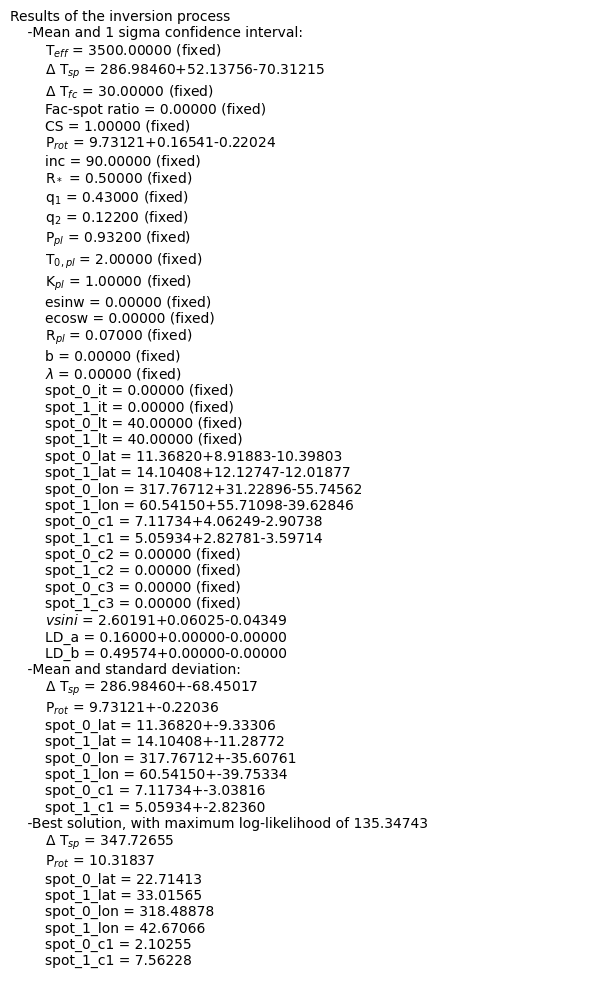

In [25]:
ss=starsim.StarSim(conf_file_path='starsim.conf') #initialize configuration and spot map
ss.load_data(t=t_sampling,y=y_lc,yerr=dy_lc,instrument='DUMMY-lc',observable='lc',filter_name='TJO_R.dat',wvmin=5500,wvmax=9500,offset=1,jitter=0,fix_offset=True,fix_jitter=False)
ss.load_data(t=t_sampling,y=y_rv,yerr=dy_rv,instrument='DUMMY-rv',observable='rv',wvmin=5500,wvmax=9500,offset=0,jitter=0,fix_offset=True,fix_jitter=False)

ss.optimize_MCMC()

In [33]:
ss.plot_MCMCoptimization_chain()
ss.plot_MCMCoptimization_likelihoods()
ss.plot_MCMCoptimization_corner()
ss.plot_MCMCoptimization_results(t=np.linspace(t_sampling[0],t_sampling[-1],200),fold=False)


 [99/100]

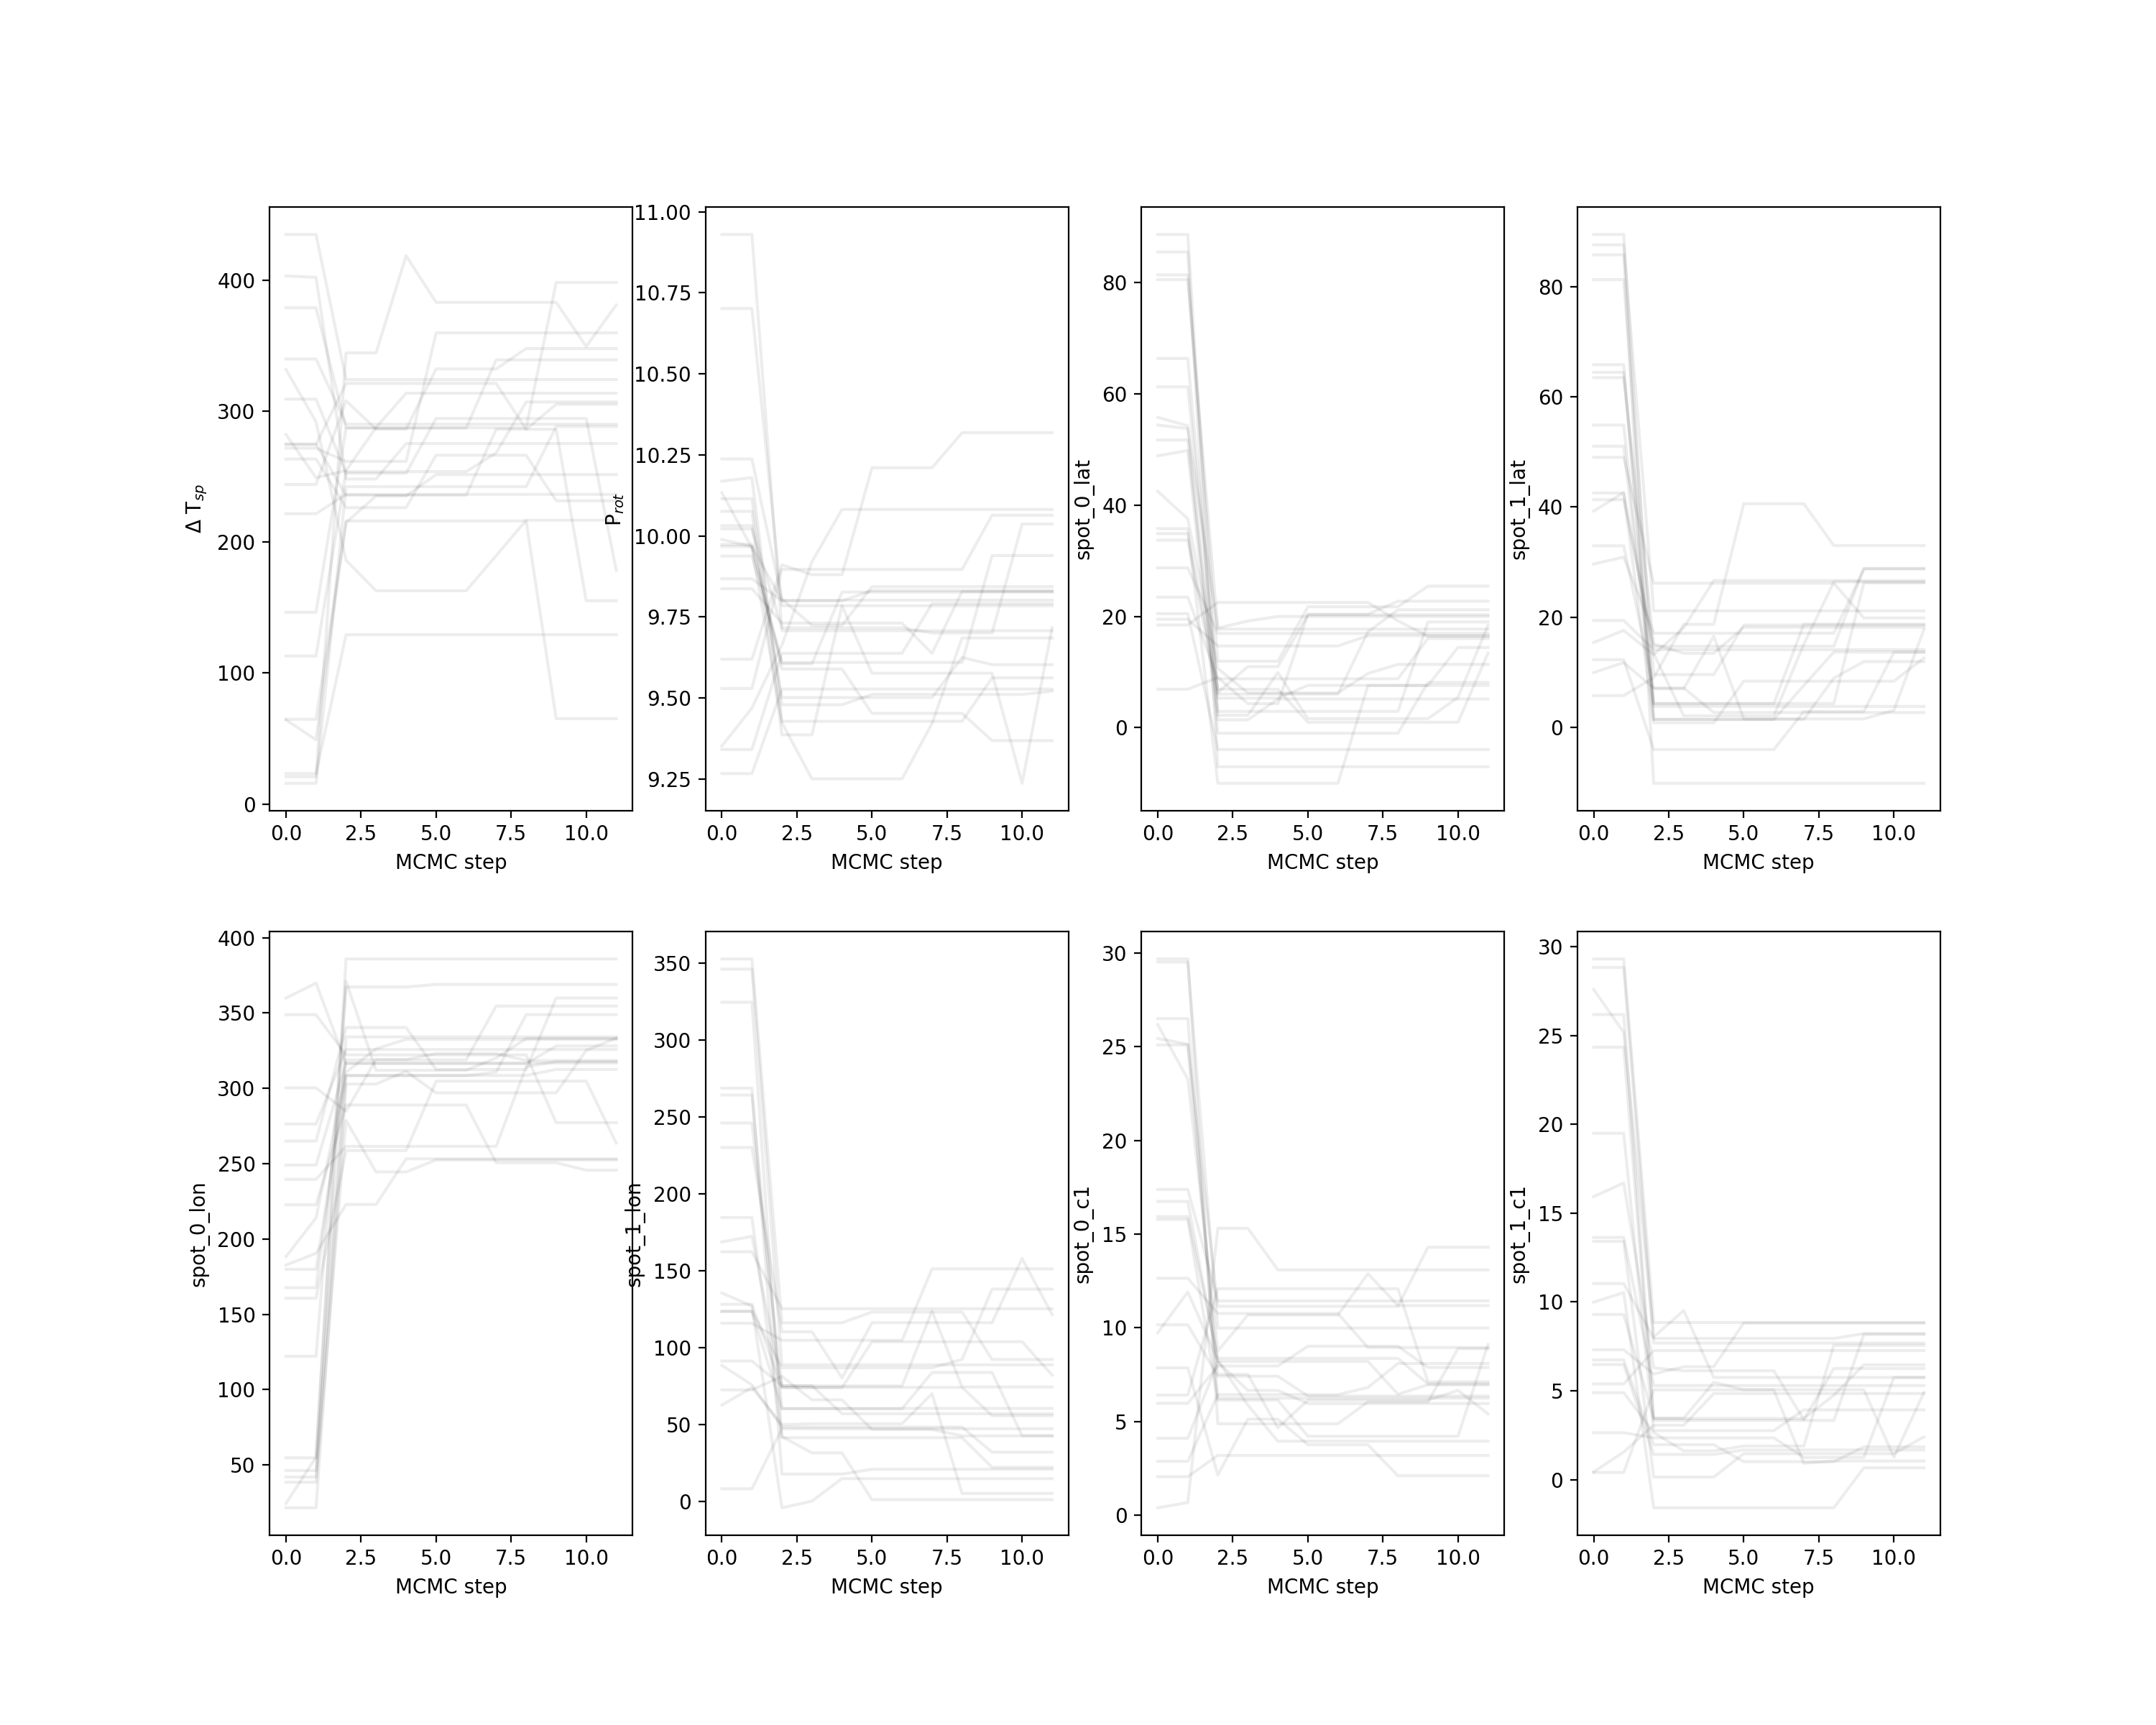

In [34]:
Image(filename='starsim/plots/MCMCoptimization_chains.png',width=800) 

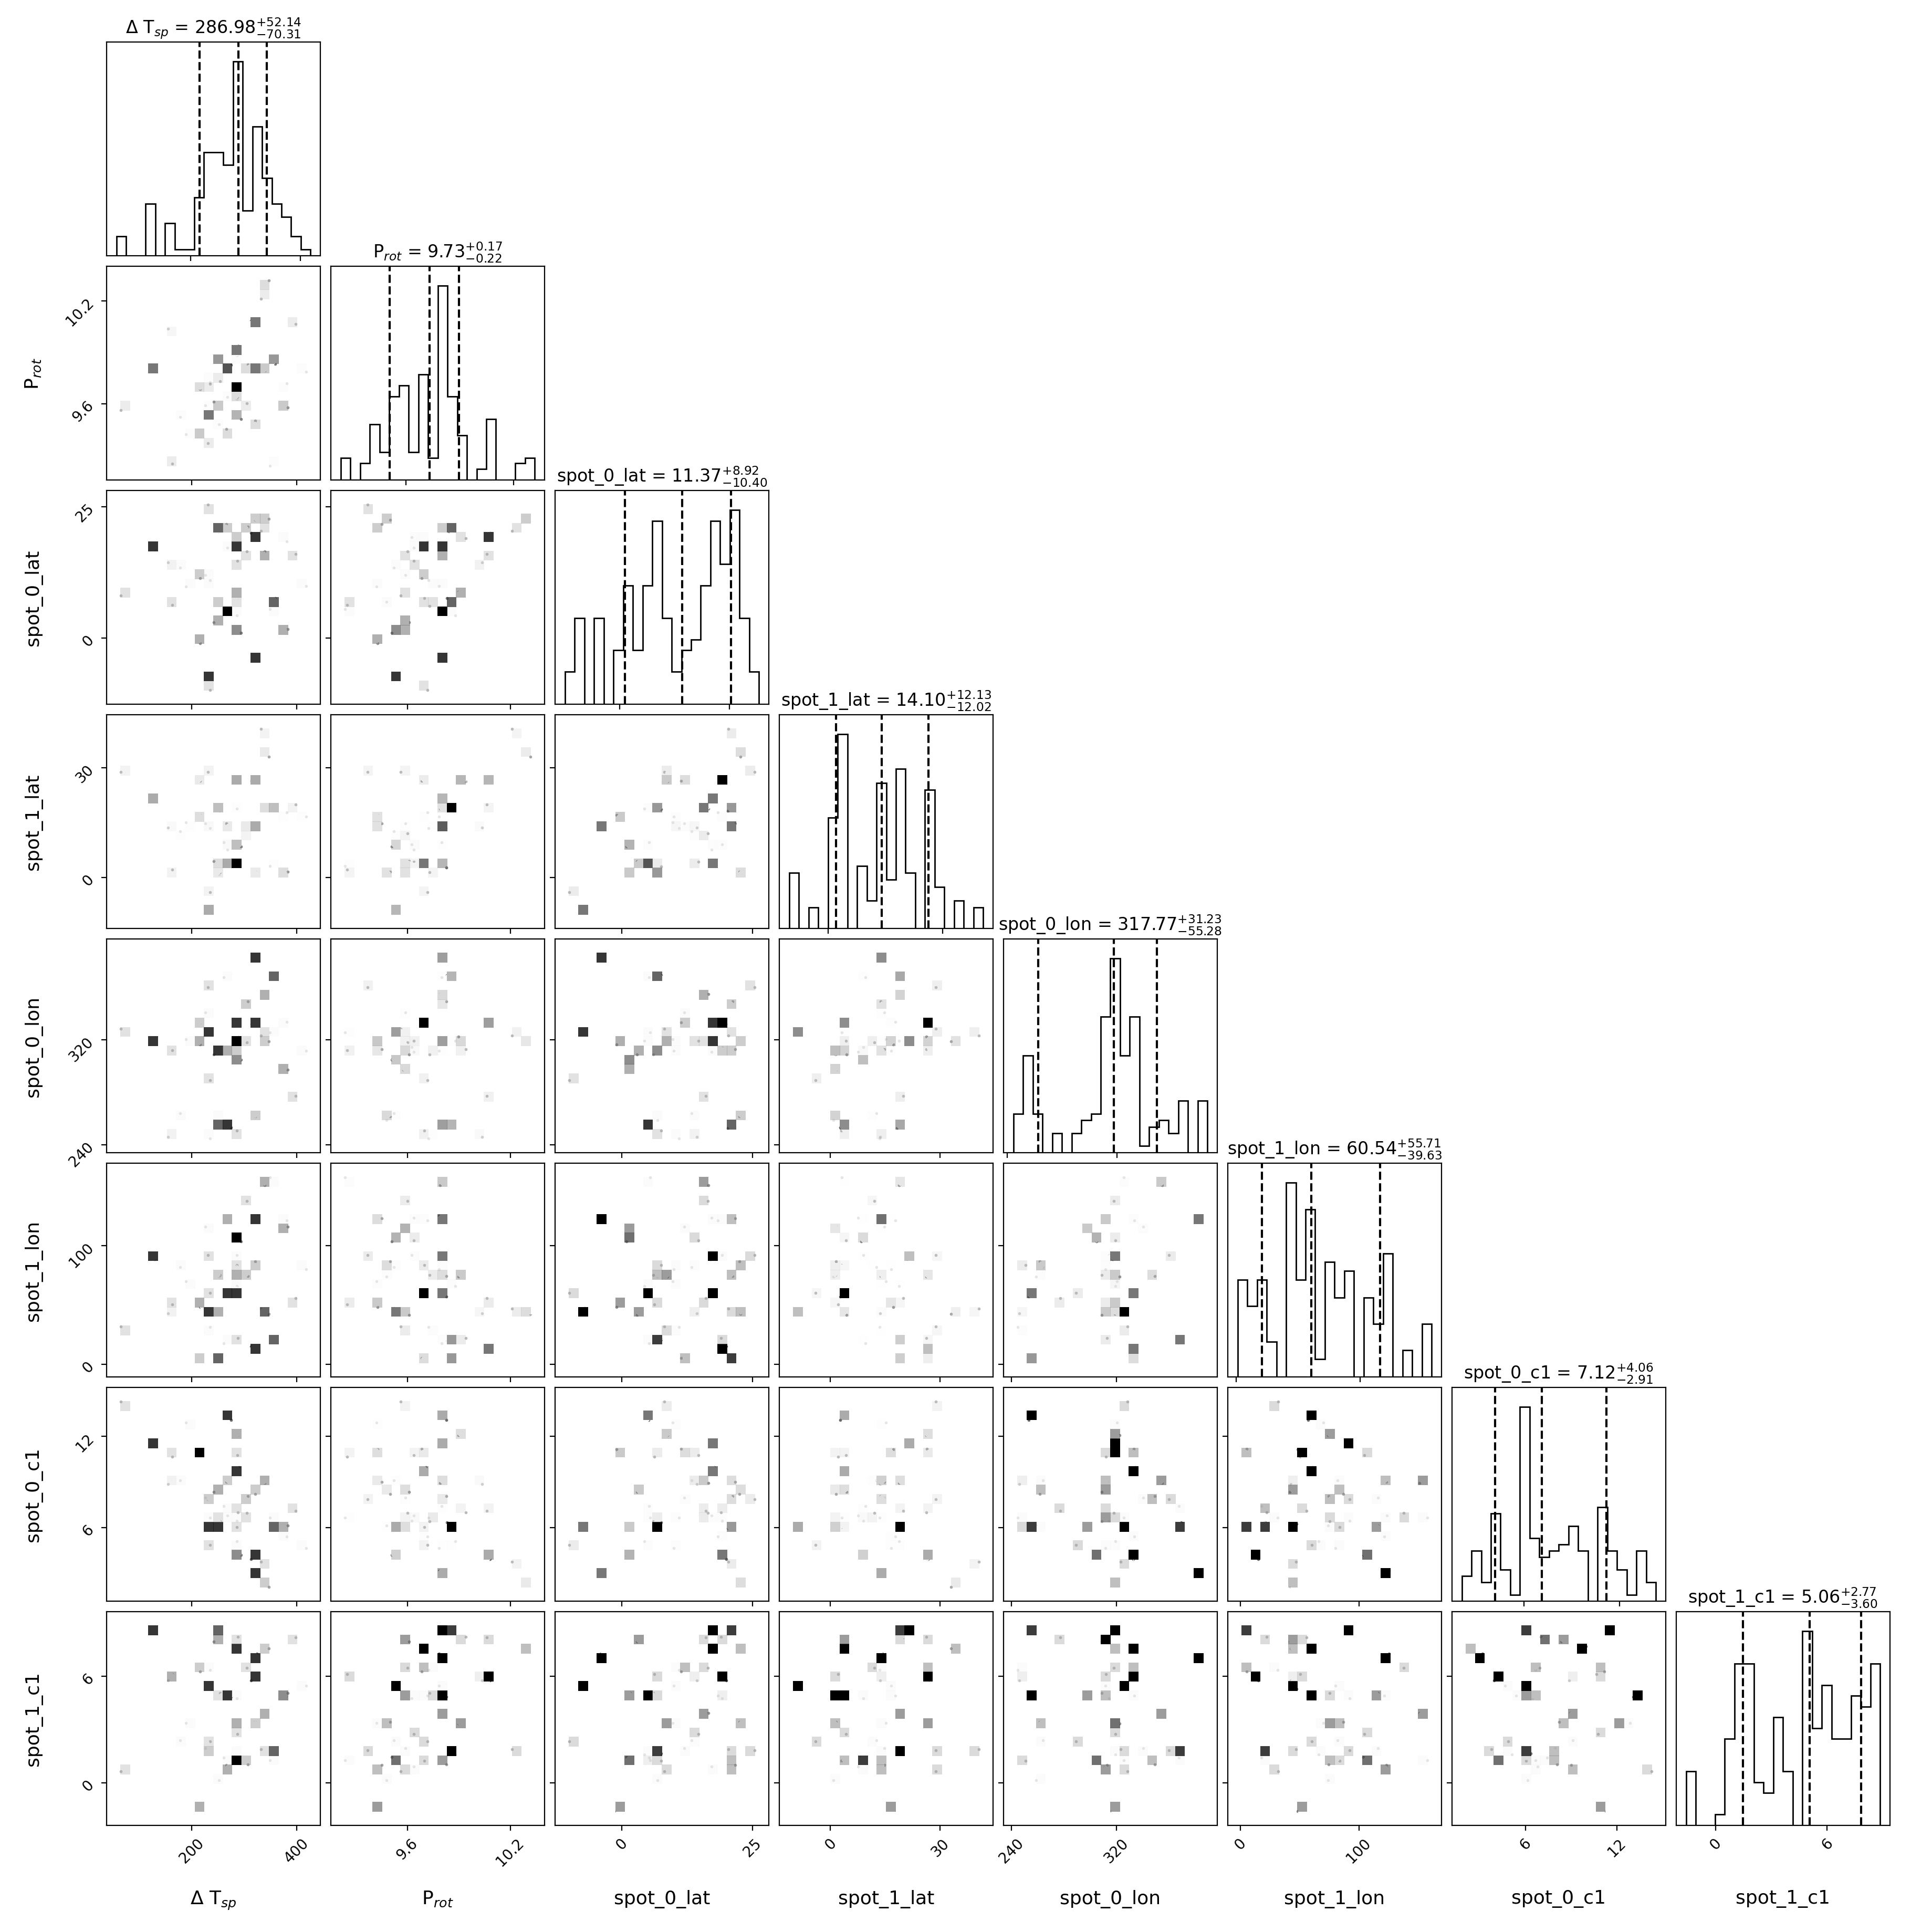

In [35]:
Image(filename='starsim/plots/MCMCoptimization_cornerplot.png',width=500) 

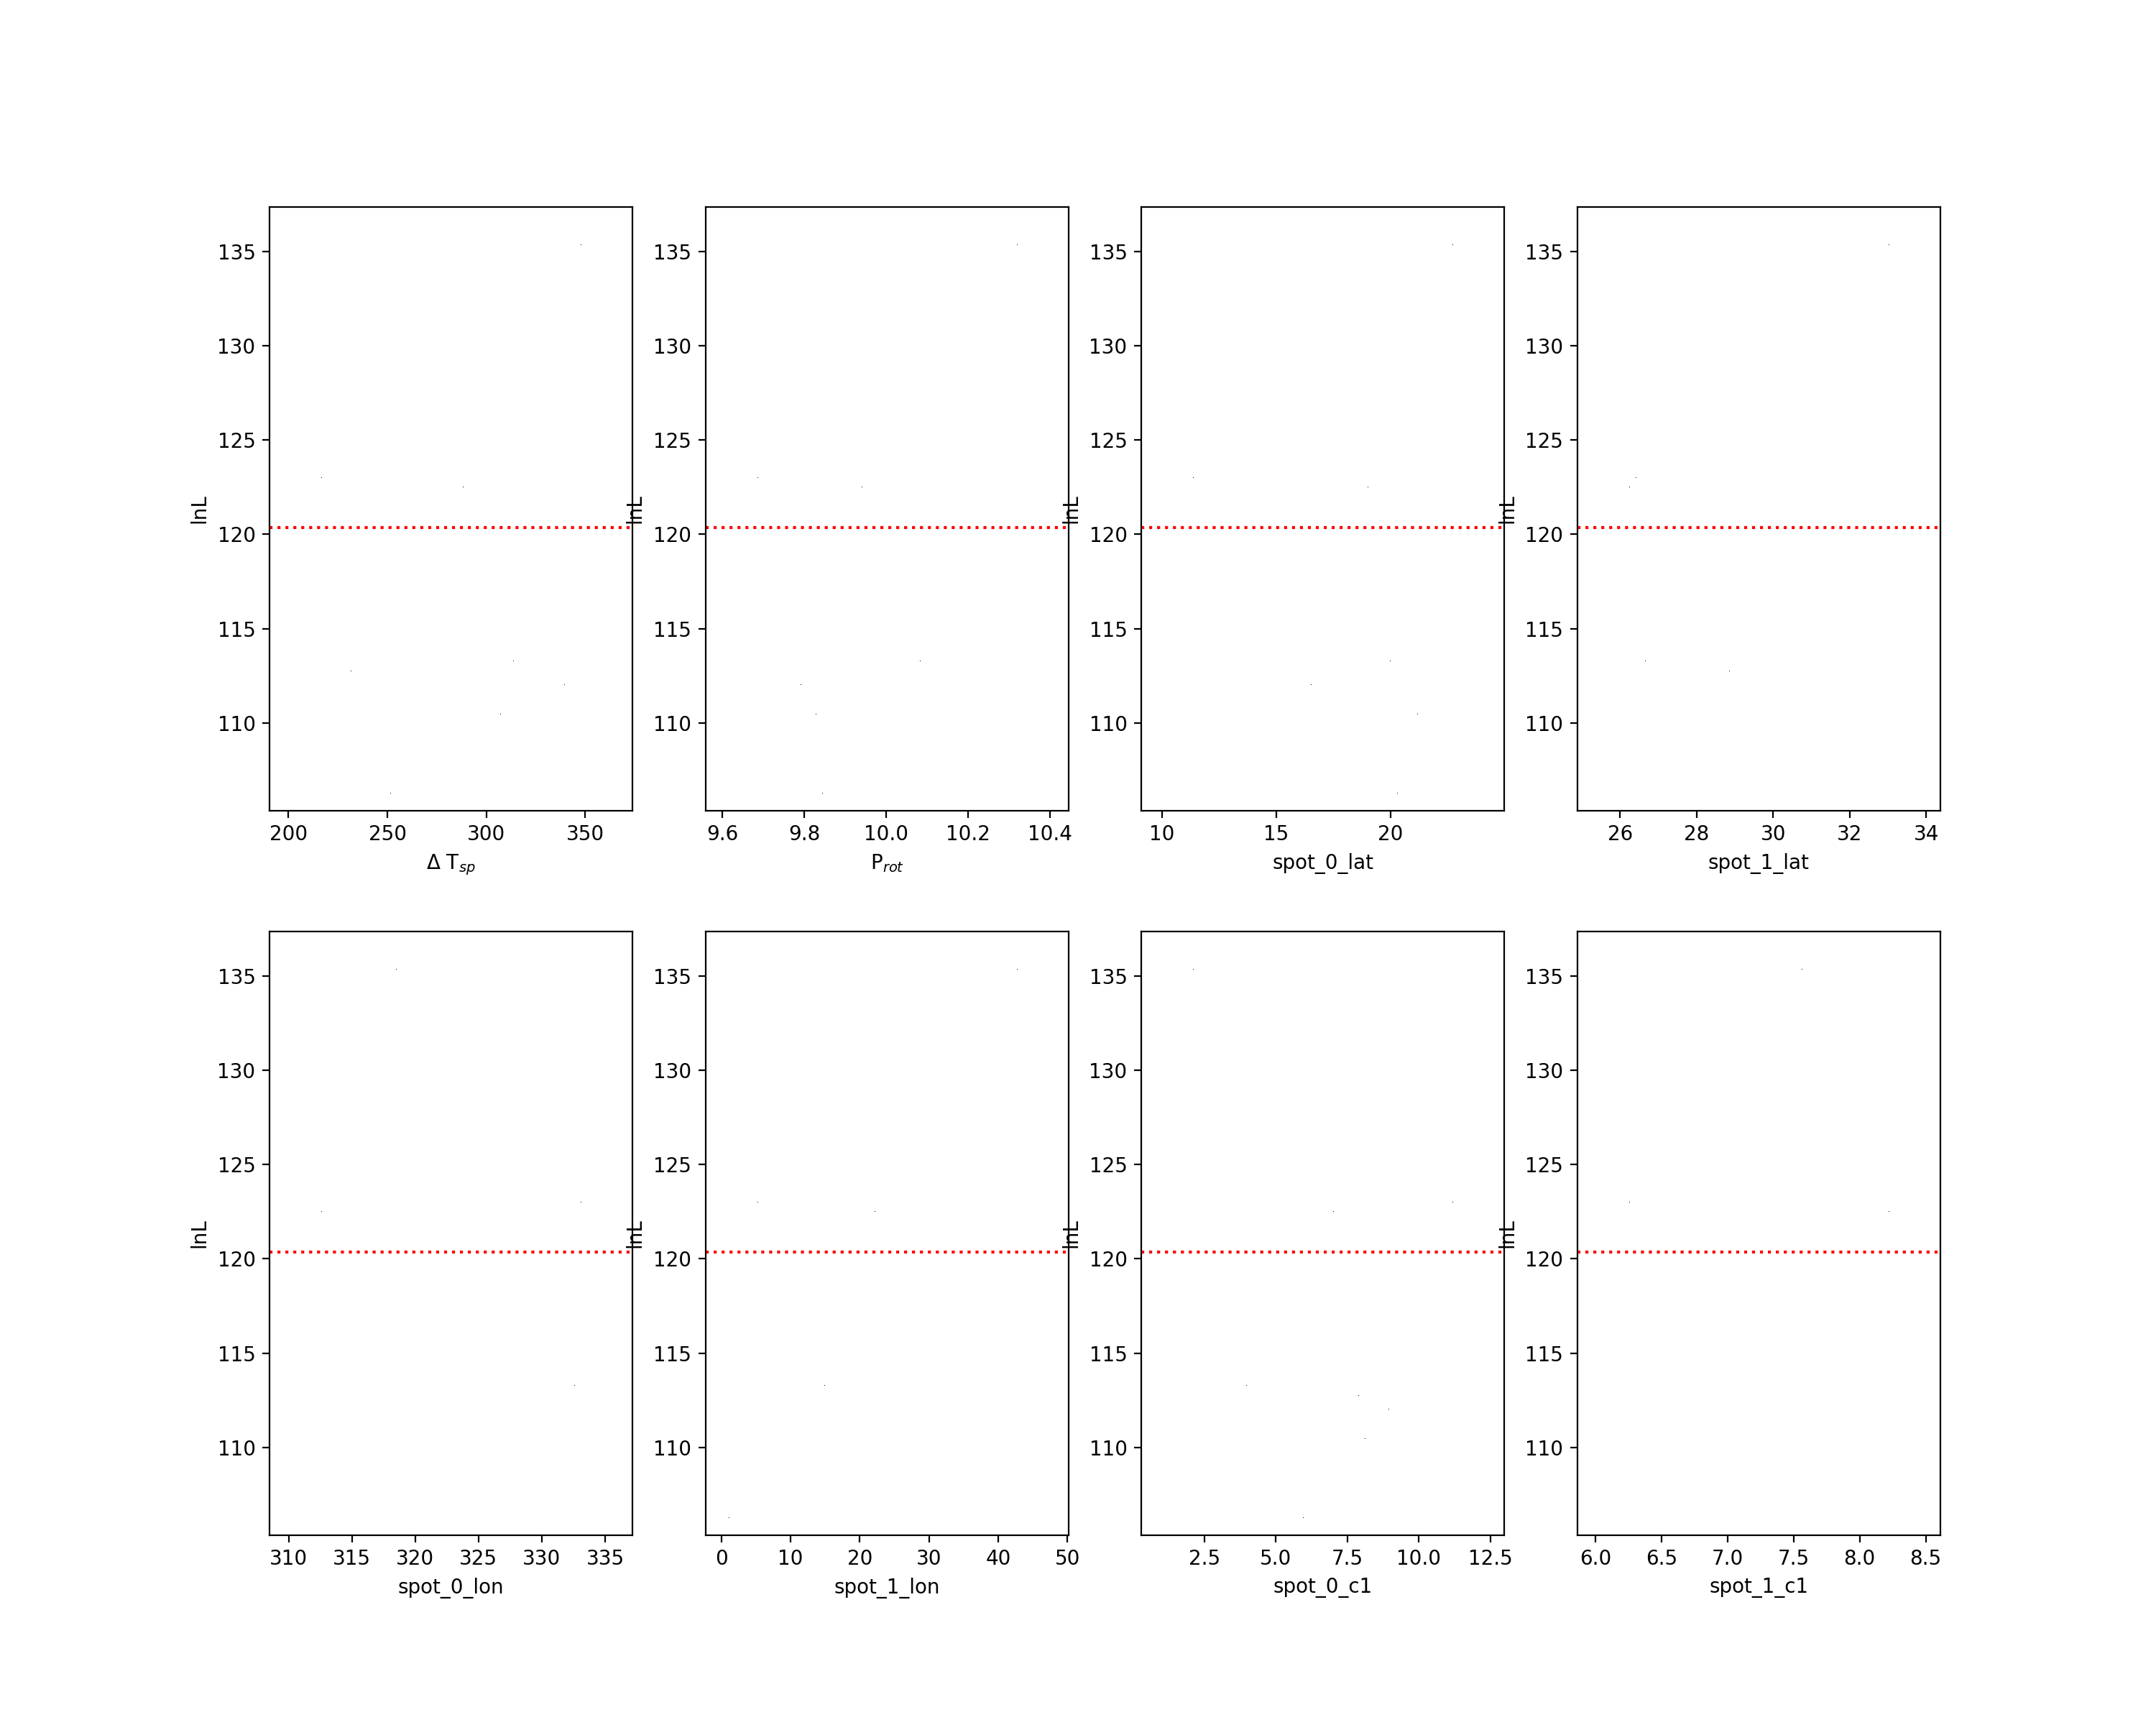

In [36]:
Image(filename='starsim/plots/MCMCoptimization_likelihoods.png',width=600) 

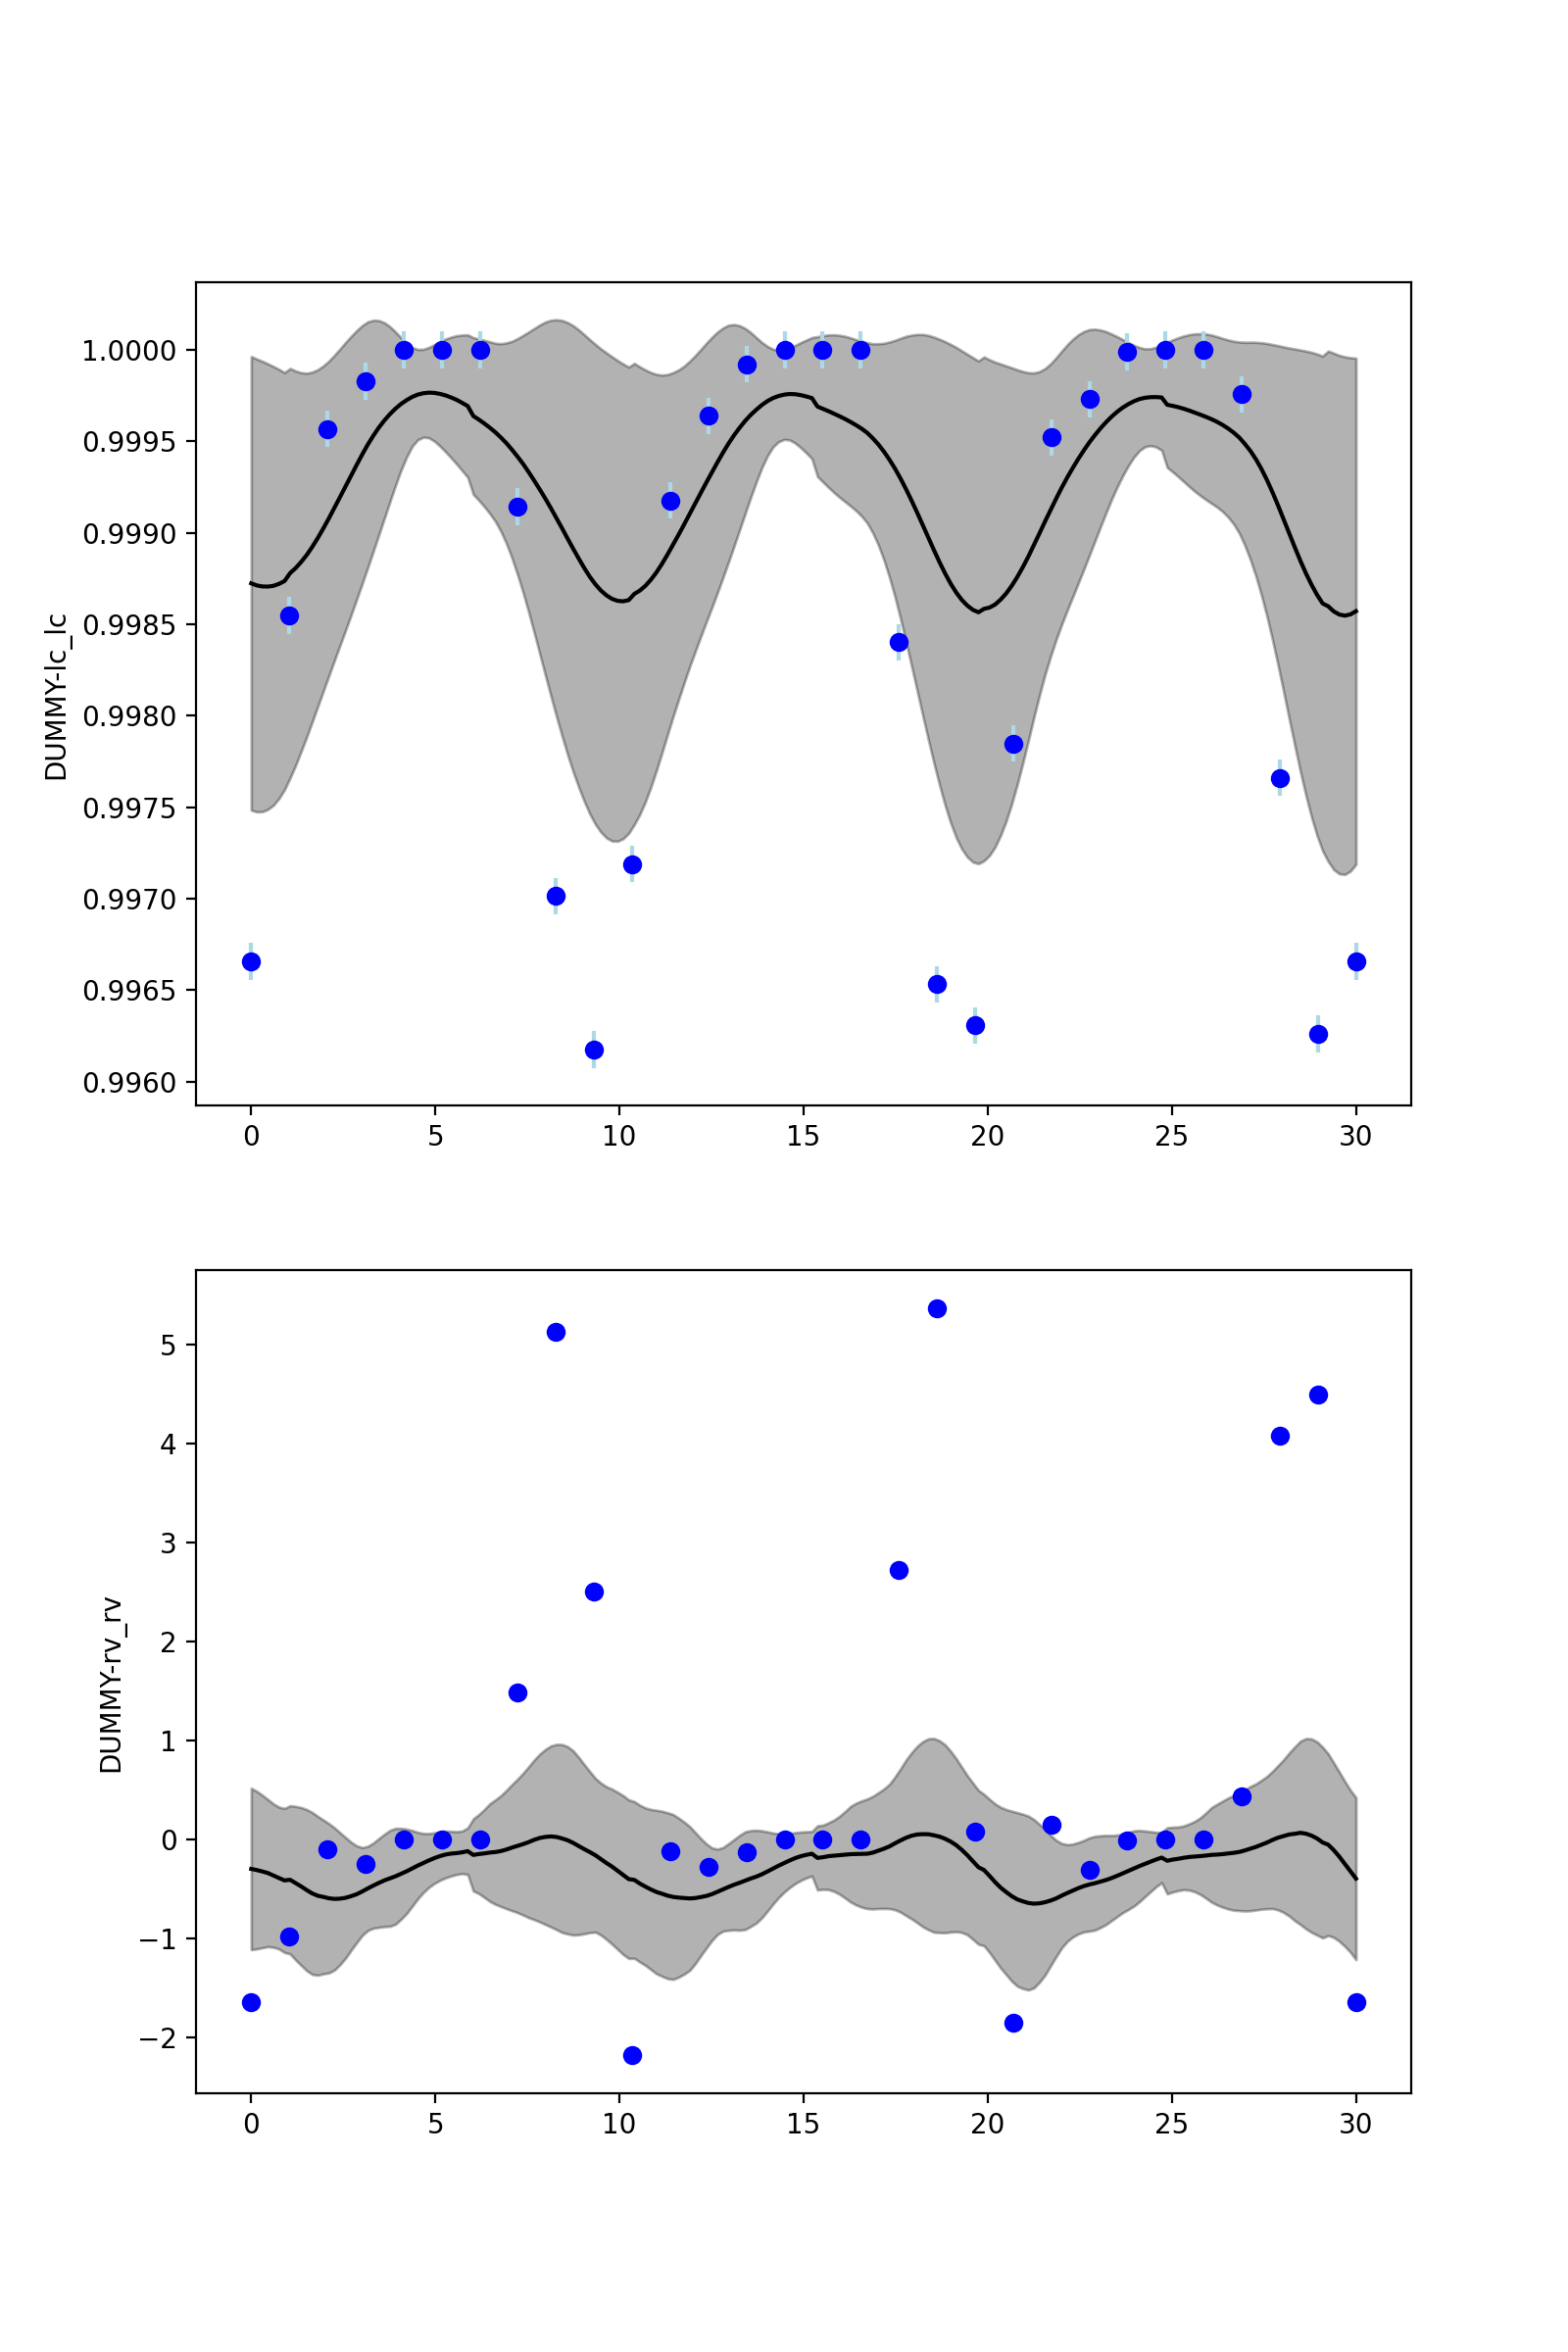

In [37]:

Image(filename='starsim/plots/MCMCoptimization_timeseries_result.png',width=300)